# Astro pipeline: target variable and XGBoost (BTC)

This notebook shows the full cycle:
1) load quotes (daily)
2) build target variable (oracle labels)
3) compute astro data and build astro features
4) train and evaluate XGBoost.

Important: features are astro-only; price is used only for targets.


## 0. Environment setup

If some packages are missing, install via conda-forge (in active env):

```
conda install -c conda-forge xgboost scikit-learn matplotlib seaborn tqdm pyarrow jupyterlab
```

Also check:
- `configs/astro.yaml` -> `ephe_path` (path to Swiss Ephemeris)
- `configs/subjects.yaml` -> `active_subject_id` and subject birth date


In [1]:

# --- TRACE HELPERS (auto-generated) ---
import inspect as _inspect
from pathlib import Path as _Path

TRACE_MAX_COLS = 25


def _format_value(val, max_items=5):
    try:
        import pandas as _pd
    except Exception:
        _pd = None
    try:
        import numpy as _np
    except Exception:
        _np = None

    if _inspect.ismodule(val):
        return f"<module {getattr(val, '__name__', 'module')}>"
    if _inspect.isfunction(val) or _inspect.isclass(val):
        return f"<{type(val).__name__} {getattr(val, '__name__', '')}>"
    if isinstance(val, _Path):
        return f"Path('{val}')"
    if _pd is not None and isinstance(val, _pd.DataFrame):
        cols = list(val.columns)
        cols_preview = cols[:TRACE_MAX_COLS]
        head = val.head(3)
        return (
            f"DataFrame shape={val.shape} cols_count={len(cols)} "
            f"cols_preview={cols_preview} head=\n{head}"
        )
    if _pd is not None and isinstance(val, _pd.Series):
        head = val.head(3).to_list()
        return f"Series len={len(val)} name={val.name} head={head}"
    if _np is not None and isinstance(val, _np.ndarray):
        sample = val.flatten()[:max_items]
        return f"ndarray shape={val.shape} dtype={val.dtype} sample={sample}"
    if isinstance(val, dict):
        keys = list(val.keys())
        return f"dict keys_count={len(keys)} keys_preview={keys[:max_items]}" + ("..." if len(keys) > max_items else "")
    if isinstance(val, (list, tuple, set)):
        lst = list(val)
        return f"{type(val).__name__} len={len(lst)} sample={lst[:max_items]}" + ("..." if len(lst) > max_items else "")
    if isinstance(val, str):
        if len(val) > 200:
            return repr(val[:200] + '...')
        return repr(val)
    try:
        return repr(val)
    except Exception:
        return f"<{type(val).__name__}>"


def trace_cell(title, purpose=None, used_vars=None, notes=None, show_missing=False, **kwargs):
    print("\n" + "=" * 120)
    print(f"[CELL] {title}")
    if purpose:
        print(f"Purpose: {purpose}")
    if notes:
        print("Notes:")
        for n in notes:
            print(f"- {n}")
    if used_vars:
        print("Variables used in this cell:")
        for name in used_vars:
            if name in globals():
                val = globals()[name]
                expl = VAR_HELP.get(name)
                if expl:
                    print(f"  {name} ({expl}) = {_format_value(val)}")
                else:
                    print(f"  {name} = {_format_value(val)}")
            else:
                if show_missing:
                    print(f"  {name} = <not set>")
    print("=" * 120)

VAR_HELP = {'center': "astro coordinate center ('geo' or 'helio')", 'price_mode': "oracle price_mode: 'log' or 'raw'", 'LABEL_PRICE_MODE': "labeling price space: 'log' or 'raw'", 'LABEL_MODE': 'labeling mode (balanced_future_return / balanced_detrended)', 'GAUSS_WINDOW': 'Gaussian window size (odd) for centered detrend', 'GAUSS_STD': 'Gaussian std for centered detrend', 'HORIZON': 'prediction horizon (days ahead)', 'TARGET_MOVE_SHARE': 'target share of samples kept for balanced labeling', 'MOVE_SHARE_TOTAL': 'total share kept (split up/down)', 'cfg_market': 'market config loaded from configs/market.yaml', 'cfg_astro': 'astro config loaded from configs/astro.yaml', 'cfg_labels': 'labels config loaded from configs/labels.yaml', 'df_market': 'market DataFrame (daily OHLCV)', 'df_bodies': 'astro bodies table (daily)', 'df_aspects': 'astro aspects table (daily)', 'df_transits': 'transit-to-natal aspects table (daily)', 'df_features': 'feature matrix (astro features)', 'df_labels': 'oracle labels table', 'feature_cols': 'feature column names used for model training', 'TWO_STAGE': 'two-stage XGB (move + direction) flag', 'model': 'single-stage model wrapper', 'model_move': 'two-stage move model', 'model_dir': 'two-stage direction model'}

# Check dependencies (stop notebook if missing)
import importlib.util as iu
from sklearn.utils.class_weight import compute_sample_weight
import sys
from pathlib import Path
# Ensure repo root is on sys.path so src/ imports work
_ROOT = Path.cwd()
if not (_ROOT / "src").exists():
    if (_ROOT.parent / "src").exists():
        _ROOT = _ROOT.parent
    elif (_ROOT.parent.parent / "src").exists():
        _ROOT = _ROOT.parent.parent
if str(_ROOT) not in sys.path:
    sys.path.insert(0, str(_ROOT))

from src.models.xgb import XGBBaseline

required = ["xgboost", "sklearn", "matplotlib", "seaborn", "tqdm", "pyarrow"]
missing = [pkg for pkg in required if iu.find_spec(pkg) is None]

if missing:
    print("Missing packages:", ", ".join(missing))
    print("Install them with:")
    print("conda install -c conda-forge xgboost scikit-learn matplotlib seaborn tqdm pyarrow jupyterlab")
    raise SystemExit("Stopped: install dependencies and rerun")

print("OK: all core dependencies found")




trace_cell(
    title='Cell 2',
    purpose='--- TRACE HELPERS (auto-generated) ---',
    used_vars=['iu', 'missing', 'pkg', 'required'],
    show_missing=False,
)


OK: all core dependencies found

[CELL] Cell 2
Purpose: --- TRACE HELPERS (auto-generated) ---
Variables used in this cell:
  iu = <module importlib.util>
  missing = list len=0 sample=[]
  required = list len=6 sample=['xgboost', 'sklearn', 'matplotlib', 'seaborn', 'tqdm']...


In [2]:

# Base imports and environment setup
from pathlib import Path
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Visual style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

# Table display settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# Project root search (look for configs/market.yaml)
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "configs/market.yaml").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "configs/market.yaml").exists():
            PROJECT_ROOT = parent
            break

if not (PROJECT_ROOT / "configs/market.yaml").exists():
    raise FileNotFoundError("Project root not found: configs/market.yaml")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"PROJECT_ROOT = {PROJECT_ROOT}")




trace_cell(
    title='Cell 3',
    purpose='Base imports and environment setup',
    used_vars=['PROJECT_ROOT', 'Path', 'parent', 'pd', 'plt', 'sns', 'sys'],
    show_missing=False,
)


PROJECT_ROOT = C:\_PYTH\projects\PythonProject\ostrofun

[CELL] Cell 3
Purpose: Base imports and environment setup
Variables used in this cell:
  PROJECT_ROOT = Path('C:\_PYTH\projects\PythonProject\ostrofun')
  Path = <type Path>
  parent = Path('C:\_PYTH\projects\PythonProject\ostrofun')
  pd = <module pandas>
  plt = <module matplotlib.pyplot>
  sns = <module seaborn>
  sys = <module sys>


In [3]:
# Load configs and market data (DB + parquet/CSV)
from src.common.config import load_yaml, load_subjects
from src.db.connection import psql_connection
from src.market.loader import load_market_daily_parquet, load_market_daily_csv

cfg_market = load_yaml(PROJECT_ROOT / "configs/market.yaml")
cfg_astro = load_yaml(PROJECT_ROOT / "configs/astro.yaml")
cfg_labels = load_yaml(PROJECT_ROOT / "configs/labels.yaml")
cfg_db = load_yaml(PROJECT_ROOT / "configs/db.yaml")
cfg_train = load_yaml(PROJECT_ROOT / "configs/training.yaml")

subjects, active_id = load_subjects(PROJECT_ROOT / "configs/subjects.yaml")
subject = subjects[active_id]

market_cfg = cfg_market["market"]

# NOTE: if path is relative, resolve from PROJECT_ROOT
def _resolve_path(value: str | Path) -> Path:
    path = Path(value)
    if path.is_absolute():
        return path
    return (PROJECT_ROOT / path).resolve()

data_root = _resolve_path(market_cfg["data_root"])
processed_dir = data_root / "processed"
reports_dir = data_root / "reports"
reports_dir.mkdir(parents=True, exist_ok=True)

print(f"Active subject: {subject.subject_id}")
print(f"Data root: {data_root}")

# Load market_daily from DB (if configured) and/or parquet/CSV, then use freshest merged
db_url = (cfg_db.get("db") or {}).get("url", "")

df_db = None
if db_url:
    try:
        with psql_connection(db_url) as conn:
            df_db = pd.read_sql_query(
                "SELECT date, close FROM market_daily WHERE subject_id = %s ORDER BY date",
                conn,
                params=(subject.subject_id,),
            )
    except Exception as e:
        print(f"[WARN] DB load failed: {e}")
        df_db = None

market_parquet = processed_dir / f"{subject.subject_id}_market_daily.parquet"
market_csv = processed_dir / f"{subject.subject_id}_market_daily.csv"
df_parq = None
if market_parquet.exists():
    try:
        df_parq = load_market_daily_parquet(market_parquet)
    except Exception as e:
        print(f"[WARN] Parquet load failed: {e}")
        df_parq = None

if df_parq is None and market_csv.exists():
    try:
        df_parq = load_market_daily_csv(market_csv)
    except Exception as e:
        print(f"[WARN] CSV load failed: {e}")
        df_parq = None

frames = []
if df_db is not None and not df_db.empty:
    df_db = df_db.copy()
    df_db["date"] = pd.to_datetime(df_db["date"])
    frames.append(df_db)
    print(f"DB rows: {len(df_db)} | max date: {df_db['date'].max().date()}")
if df_parq is not None and not df_parq.empty:
    df_parq = df_parq.copy()
    df_parq["date"] = pd.to_datetime(df_parq["date"])
    frames.append(df_parq)
    print(f"File rows: {len(df_parq)} | max date: {df_parq['date'].max().date()}")

if not frames:
    raise ValueError(
        f"No market data found for subject_id={subject.subject_id}."
        " Load market_daily into Postgres or create parquet/CSV."
    )

if len(frames) == 1:
    df_market = frames[0]
else:
    df_market = pd.concat(frames, ignore_index=True)
    df_market = df_market.drop_duplicates(subset=["date"], keep="last")

if "date" not in df_market.columns or "close" not in df_market.columns:
    raise ValueError("market_daily must have date and close columns")

# Cut data from November 2017 (start only, no end cap)
DATA_START = pd.Timestamp("2017-11-01")
pre_rows = len(df_market)
df_market = df_market[df_market["date"] >= DATA_START].copy()
df_market = df_market.sort_values("date").reset_index(drop=True)
print(f"Filtered market >= {DATA_START.date()} | rows: {pre_rows} -> {len(df_market)}")

print(df_market.head())
print(f"Market range: {df_market['date'].min().date()} -> {df_market['date'].max().date()}")
print(f"Rows: {len(df_market)}")

# Plot price mode (optional override)
NB_PLOT_PRICE_MODE = None  # 'log' or 'raw'
PLOT_PRICE_MODE = str(NB_PLOT_PRICE_MODE or cfg_labels['labels'].get('price_mode', 'log')).lower()
if PLOT_PRICE_MODE not in {'log', 'raw'}:
    print(f"[WARN] Unknown PLOT_PRICE_MODE={PLOT_PRICE_MODE}, fallback to 'log'")
    PLOT_PRICE_MODE = 'log'
print(f"PLOT_PRICE_MODE = {PLOT_PRICE_MODE}")




trace_cell(
    title='Cell 4',
    purpose='Load configs and market data (DB + parquet/CSV)',
    used_vars=['DATA_START', 'NB_PLOT_PRICE_MODE', 'PLOT_PRICE_MODE', 'PROJECT_ROOT', '_resolve_path', 'active_id', 'cfg_db', 'cfg_labels', 'cfg_market', 'data_root', 'db_url', 'df_db', 'df_market', 'df_parq', 'load_subjects', 'load_yaml', 'market_cfg', 'market_parquet', 'market_csv', 'pd', 'processed_dir', 'reports_dir', 'subject', 'subjects'],
    notes=['Uses DB and/or parquet/CSV, then takes freshest merged set.', 'Market dataframe is the price source for labels/plots.'],
    show_missing=False,
)



Active subject: btc
Data root: C:\_PYTH\projects\PythonProject\ostrofun\data\market
DB rows: 5677 | max date: 2026-01-31
File rows: 3014 | max date: 2026-01-31
Filtered market >= 2017-11-01 | rows: 5677 -> 3014
        date   close
0 2017-11-01  6737.8
1 2017-11-02  7024.8
2 2017-11-03  7152.1
3 2017-11-04  7363.8
4 2017-11-05  7389.5
Market range: 2017-11-01 -> 2026-01-31
Rows: 3014
PLOT_PRICE_MODE = raw

[CELL] Cell 4
Purpose: Load configs and market data (DB + parquet/CSV)
Notes:
- Uses DB and/or parquet/CSV, then takes freshest merged set.
- Market dataframe is the price source for labels/plots.
Variables used in this cell:
  DATA_START = Timestamp('2017-11-01 00:00:00')
  NB_PLOT_PRICE_MODE = None
  PLOT_PRICE_MODE = 'raw'
  PROJECT_ROOT = Path('C:\_PYTH\projects\PythonProject\ostrofun')
  _resolve_path = <function _resolve_path>
  active_id = 'btc'
  cfg_db = dict keys_count=1 keys_preview=['db']
  cfg_labels (labels config loaded from configs/labels.yaml) = dict keys_count=1 key

C:\Users\admin\AppData\Local\Temp\ipykernel_391312\1340152101.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_db = pd.read_sql_query(


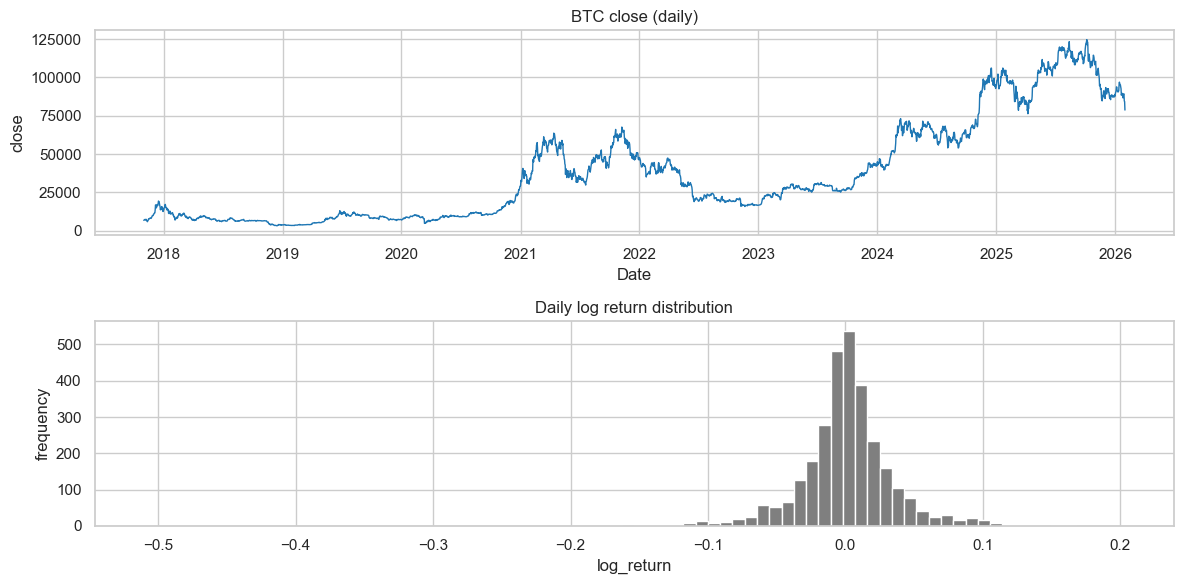


[CELL] Cell 5
Purpose: Quick look at price and daily change distribution
Notes:
- Market dataframe is the price source for labels/plots.
Variables used in this cell:
  PLOT_PRICE_MODE = 'raw'
  ax = ndarray shape=(2,) dtype=object sample=[<Axes: title={'center': 'BTC close (daily)'}, xlabel='Date', ylabel='close'>
 <Axes: title={'center': 'Daily log return distribution'}, xlabel='log_return', ylabel='frequency'>]
  df_market (market DataFrame (daily OHLCV)) = DataFrame shape=(3014, 2) cols_count=2 cols_preview=['date', 'close'] head=
        date   close
0 2017-11-01  6737.8
1 2017-11-02  7024.8
2 2017-11-03  7152.1
  log_ret = Series len=3013 name=close head=[0.041713282918156125, 0.017959274812724857, 0.029170083973008687]
  np = <module numpy>
  plt = <module matplotlib.pyplot>
  price_label = 'close'
  price_series = Series len=3014 name=close head=[6737.8, 7024.8, 7152.1]


In [4]:

# Quick look at price and daily change distribution
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=False)

price_series = np.log(df_market['close']) if PLOT_PRICE_MODE == 'log' else df_market['close']
price_label = 'log(close)' if PLOT_PRICE_MODE == 'log' else 'close'

ax[0].plot(df_market['date'], price_series, color='tab:blue', linewidth=1)
ax[0].set_title('BTC close (daily)')
ax[0].set_xlabel('Date')
ax[0].set_ylabel(price_label)

# Log returns for a rough distribution check
log_ret = np.log(df_market['close']).diff().dropna()
ax[1].hist(log_ret, bins=80, color='tab:gray')
ax[1].set_title('Daily log return distribution')
ax[1].set_xlabel('log_return')
ax[1].set_ylabel('frequency')

plt.tight_layout()
plt.show()




trace_cell(
    title='Cell 5',
    purpose='Quick look at price and daily change distribution',
    used_vars=['PLOT_PRICE_MODE', 'ax', 'df_market', 'log_ret', 'np', 'plt', 'price_label', 'price_series'],
    notes=['Market dataframe is the price source for labels/plots.'],
    show_missing=False,
)


## 1. Oracle labels (target variable)

Idea: smooth log price, take slope, classify by threshold.


In [5]:

# Balanced binary labeling based on future return
# This creates an UP/DOWN target with roughly balanced classes.

labels_cfg = cfg_labels['labels']
HORIZON = int(labels_cfg.get('horizon', 1))
TARGET_MOVE_SHARE = float(labels_cfg.get('target_move_share', 0.5))

LABEL_MODE = 'balanced_detrended'  # 'balanced_future_return' or 'balanced_detrended'
LABEL_PRICE_MODE = 'raw'  # 'raw' or 'log' for labeling space
MOVE_SHARE_TOTAL = float(TARGET_MOVE_SHARE)  # total share of samples kept (split UP/DOWN)

# Centered Gaussian smoothing for detrending (no lag)
GAUSS_WINDOW = int(labels_cfg.get('gauss_window', 201))  # must be odd
GAUSS_STD = float(labels_cfg.get('gauss_std', 50.0))


def _gaussian_kernel(window: int, std: float) -> np.ndarray:
    if window % 2 == 0:
        raise ValueError('GAUSS_WINDOW must be odd')
    x = np.arange(window) - window // 2
    w = np.exp(-(x ** 2) / (2 * (std ** 2)))
    w /= w.sum()
    return w


def _gaussian_smooth_centered(series: pd.Series, window: int, std: float) -> pd.Series:
    weights = _gaussian_kernel(window, std)
    # full window only to avoid edge bias; edges become NaN
    return series.rolling(window=window, center=True, min_periods=window).apply(
        lambda x: np.dot(x, weights), raw=True
    )


if LABEL_PRICE_MODE == 'log':
    base_series = np.log(df_market['close']).astype(float)
elif LABEL_PRICE_MODE == 'raw':
    base_series = df_market['close'].astype(float)
else:
    raise ValueError(f'Unknown LABEL_PRICE_MODE={LABEL_PRICE_MODE}')

if LABEL_MODE == 'balanced_detrended':
    smooth = _gaussian_smooth_centered(base_series, GAUSS_WINDOW, GAUSS_STD)
    base = base_series - smooth
    future_ret = base.shift(-HORIZON) - base
else:
    # Plain future return in selected price space
    future_ret = base_series.shift(-HORIZON) - base_series

valid = future_ret.dropna()
total_n = len(valid)
if total_n == 0:
    raise ValueError('No valid future returns for labeling')

# Choose top-N UP and top-N DOWN by absolute size (balanced)
per_side = max(1, int(total_n * MOVE_SHARE_TOTAL / 2))
pos = valid[valid > 0]
neg = valid[valid < 0]
n_up = min(per_side, len(pos))
n_down = min(per_side, len(neg))

up_idx = pos.nlargest(n_up).index
down_idx = neg.nsmallest(n_down).index  # most negative

df_labels = df_market.copy()
df_labels['target'] = np.nan
df_labels.loc[up_idx, 'target'] = 1
df_labels.loc[down_idx, 'target'] = 0

df_labels = df_labels.dropna(subset=['target']).reset_index(drop=True)
df_labels['target'] = df_labels['target'].astype(int)

BINARY_TREND = True
print(f'Label mode: {LABEL_MODE}, price_mode={LABEL_PRICE_MODE}, horizon={HORIZON}, move_share_total={MOVE_SHARE_TOTAL}')
if LABEL_MODE == 'balanced_detrended':
    print(f'Gaussian detrend: window={GAUSS_WINDOW}, std={GAUSS_STD}')
print(df_labels[['date', 'close', 'target']].head())




trace_cell(
    title='Cell 7',
    purpose='Balanced binary labeling based on future return',
    used_vars=['GAUSS_STD', 'GAUSS_WINDOW', 'HORIZON', 'LABEL_MODE', 'LABEL_PRICE_MODE', 'MOVE_SHARE_TOTAL', 'TARGET_MOVE_SHARE', '_gaussian_smooth_centered', 'base', 'base_series', 'cfg_labels', 'df_labels', 'df_market', 'down_idx', 'future_ret', 'labels_cfg', 'n_down', 'n_up', 'neg', 'np', 'per_side', 'pos', 'smooth', 'total_n', 'up_idx', 'valid'],
    notes=['Market dataframe is the price source for labels/plots.', 'Oracle labels (targets) for training/eval.'],
    show_missing=False,
)


Label mode: balanced_detrended, price_mode=raw, horizon=1, move_share_total=0.5
Gaussian detrend: window=201, std=50.0
        date    close  target
0 2018-02-10   8559.6       0
1 2018-02-11   8081.9       1
2 2018-02-13   8539.2       1
3 2018-02-14   9476.3       1
4 2018-02-16  10178.7       1

[CELL] Cell 7
Purpose: Balanced binary labeling based on future return
Notes:
- Market dataframe is the price source for labels/plots.
- Oracle labels (targets) for training/eval.
Variables used in this cell:
  GAUSS_STD (Gaussian std for centered detrend) = 50.0
  GAUSS_WINDOW (Gaussian window size (odd) for centered detrend) = 201
  HORIZON (prediction horizon (days ahead)) = 1
  LABEL_MODE (labeling mode (balanced_future_return / balanced_detrended)) = 'balanced_detrended'
  LABEL_PRICE_MODE (labeling price space: 'log' or 'raw') = 'raw'
  MOVE_SHARE_TOTAL (total share kept (split up/down)) = 0.5
  TARGET_MOVE_SHARE (target share of samples kept for balanced labeling) = 0.5
  _gaussian_sm

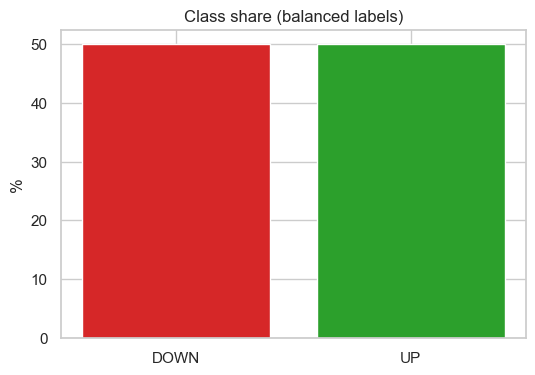


[CELL] Cell 8
Purpose: Class distribution (binary)
Notes:
- Oracle labels (targets) for training/eval.
Variables used in this cell:
  colors = list len=2 sample=['#d62728', '#2ca02c']
  counts = Series len=2 name=proportion head=[50.0, 50.0]
  df_labels (oracle labels table) = DataFrame shape=(1406, 3) cols_count=3 cols_preview=['date', 'close', 'target'] head=
        date   close  target
0 2018-02-10  8559.6       0
1 2018-02-11  8081.9       1
2 2018-02-13  8539.2       1
  label_map = dict keys_count=2 keys_preview=[0, 1]
  plt = <module matplotlib.pyplot>


In [6]:

# Class distribution (binary)
label_map = {0: 'DOWN', 1: 'UP'}
counts = df_labels['target'].value_counts(normalize=True).sort_index() * 100
colors = ['#d62728', '#2ca02c']

plt.figure(figsize=(6, 4))
plt.bar([label_map[i] for i in counts.index], counts.values, color=colors)
plt.title('Class share (balanced labels)')
plt.ylabel('%')
plt.show()




trace_cell(
    title='Cell 8',
    purpose='Class distribution (binary)',
    used_vars=['colors', 'counts', 'df_labels', 'i', 'label_map', 'plt'],
    notes=['Oracle labels (targets) for training/eval.'],
    show_missing=False,
)


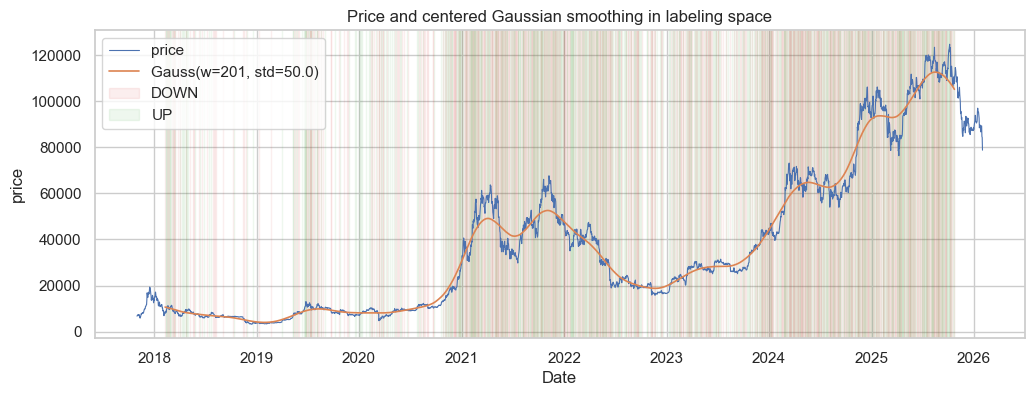


[CELL] Cell 9
Purpose: Visual: price and centered Gaussian smoothing in labeling space
Notes:
- Market dataframe is the price source for labels/plots.
- Oracle labels (targets) for training/eval.
Variables used in this cell:
  GAUSS_STD (Gaussian std for centered detrend) = 50.0
  GAUSS_WINDOW (Gaussian window size (odd) for centered detrend) = 201
  LABEL_MODE (labeling mode (balanced_future_return / balanced_detrended)) = 'balanced_detrended'
  LABEL_PRICE_MODE (labeling price space: 'log' or 'raw') = 'raw'
  _gaussian_smooth_centered = <function _gaussian_smooth_centered>
  ax = <Axes: title={'center': 'Price and centered Gaussian smoothing in labeling space'}, xlabel='Date', ylabel='price'>
  color = 'tab:green'
  color_map = dict keys_count=2 keys_preview=[0, 1]
  current_label = None
  dates = Series len=3014 name=date head=[Timestamp('2017-11-01 00:00:00'), Timestamp('2017-11-02 00:00:00'), Timestamp('2017-11-03 00:00:00')]
  df_labels (oracle labels table) = DataFrame shape=(1

In [7]:
# Visual: price and centered Gaussian smoothing in labeling space
if LABEL_PRICE_MODE == 'log':
    price_series = np.log(df_market['close']).astype(float)
    y_label = 'log(price)'
else:
    price_series = df_market['close'].astype(float)
    y_label = 'price'

smooth = None
if LABEL_MODE == 'balanced_detrended':
    smooth = _gaussian_smooth_centered(price_series, GAUSS_WINDOW, GAUSS_STD)
    if smooth.isna().all():
        print('WARNING: Gaussian smoothing is all-NaN. Reduce GAUSS_WINDOW or data length is too short.')

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(df_market['date'], price_series, label='price', linewidth=0.8)
if smooth is not None and smooth.notna().any():
    ax.plot(df_market['date'], smooth, label=f'Gauss(w={GAUSS_WINDOW}, std={GAUSS_STD})', linewidth=1.2)

# Shade labels (if available)
if 'df_labels' in globals() and 'target' in df_labels.columns:
    dates = pd.to_datetime(df_market['date'])
    label_series = pd.Series(index=dates, dtype='float')
    label_map = df_labels[['date', 'target']].copy()
    label_map['date'] = pd.to_datetime(label_map['date'])
    label_series.loc[label_map['date']] = label_map['target'].values

    unique_labels = sorted([int(x) for x in label_series.dropna().unique()])
    if set(unique_labels) <= {0, 1}:
        color_map = {0: ('DOWN', 'tab:red'), 1: ('UP', 'tab:green')}
    else:
        color_map = {0: ('DOWN', 'tab:red'), 1: ('SIDE', 'tab:gray'), 2: ('UP', 'tab:green')}

    current_label = None
    start_dt = None
    prev_dt = None
    used_labels = set()
    for dt, lab in label_series.items():
        if pd.isna(lab):
            if current_label is not None and prev_dt is not None:
                name, color = color_map.get(int(current_label), (str(int(current_label)), 'tab:gray'))
                ax.axvspan(start_dt, prev_dt, color=color, alpha=0.08, label=name if name not in used_labels else None)
                used_labels.add(name)
                current_label = None
                start_dt = None
            prev_dt = dt
            continue
        lab = int(lab)
        if current_label is None:
            current_label = lab
            start_dt = dt
        elif lab != current_label:
            name, color = color_map.get(int(current_label), (str(int(current_label)), 'tab:gray'))
            ax.axvspan(start_dt, prev_dt, color=color, alpha=0.08, label=name if name not in used_labels else None)
            used_labels.add(name)
            current_label = lab
            start_dt = dt
        prev_dt = dt

    if current_label is not None and prev_dt is not None:
        name, color = color_map.get(int(current_label), (str(int(current_label)), 'tab:gray'))
        ax.axvspan(start_dt, prev_dt, color=color, alpha=0.08, label=name if name not in used_labels else None)

ax.set_title('Price and centered Gaussian smoothing in labeling space')
ax.set_xlabel('Date')
ax.set_ylabel(y_label)
ax.legend()
plt.show()



trace_cell(
    title='Cell 9',
    purpose='Visual: price and centered Gaussian smoothing in labeling space',
    used_vars=['GAUSS_STD', 'GAUSS_WINDOW', 'LABEL_MODE', 'LABEL_PRICE_MODE', '_gaussian_smooth_centered', 'ax', 'color', 'color_map', 'current_label', 'dates', 'df_labels', 'df_market', 'dt', 'lab', 'label_map', 'label_series', 'name', 'np', 'pd', 'plt', 'prev_dt', 'price_series', 'smooth', 'start_dt', 'unique_labels', 'used_labels', 'x', 'y_label'],
    notes=['Market dataframe is the price source for labels/plots.', 'Oracle labels (targets) for training/eval.'],
    show_missing=False,
)


Histogram uses DETRENDED series: base = price - gaussian_smooth


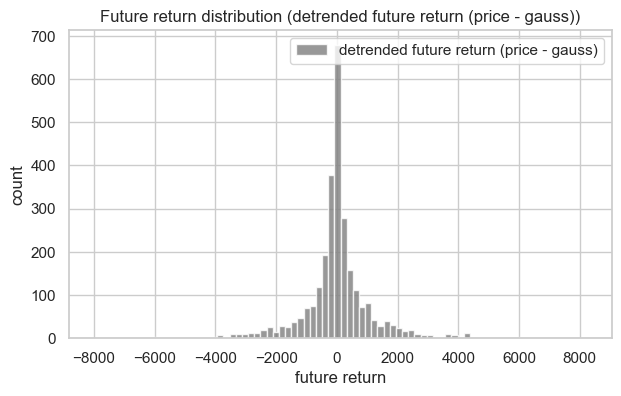


[CELL] Cell 10
Purpose: Future return distribution (labeling space)
Notes:
- Market dataframe is the price source for labels/plots.
Variables used in this cell:
  GAUSS_STD (Gaussian std for centered detrend) = 50.0
  GAUSS_WINDOW (Gaussian window size (odd) for centered detrend) = 201
  HORIZON (prediction horizon (days ahead)) = 1
  LABEL_MODE (labeling mode (balanced_future_return / balanced_detrended)) = 'balanced_detrended'
  LABEL_PRICE_MODE (labeling price space: 'log' or 'raw') = 'raw'
  SHOW_BOTH_DISTS = False
  _gaussian_smooth_centered = <function _gaussian_smooth_centered>
  base = Series len=2983 name=close head=[nan, nan, nan]
  base_series = Series len=2983 name=close head=[6737.8, 7024.8, 7152.1]
  df_market (market DataFrame (daily OHLCV)) = DataFrame shape=(2983, 2) cols_count=2 cols_preview=['date', 'close'] head=
        date   close
0 2017-11-01  6737.8
1 2017-11-02  7024.8
2 2017-11-03  7152.1
  dist_title = 'detrended future return (price - gauss)'
  future_ret 

In [8]:
# Future return distribution (labeling space)
SHOW_BOTH_DISTS = False  # if True and LABEL_MODE==balanced_detrended, overlay raw vs detrended

if LABEL_PRICE_MODE == 'log':
    base_series = np.log(df_market['close']).astype(float)
    y_label = 'log(price)'
else:
    base_series = df_market['close'].astype(float)
    y_label = 'price'

if LABEL_MODE == 'balanced_detrended':
    smooth = _gaussian_smooth_centered(base_series, GAUSS_WINDOW, GAUSS_STD)
    base = base_series - smooth
    future_ret = base.shift(-HORIZON) - base
    dist_title = 'detrended future return (price - gauss)'
    print('Histogram uses DETRENDED series: base = price - gaussian_smooth')
else:
    future_ret = base_series.shift(-HORIZON) - base_series
    dist_title = 'raw future return'
    print('Histogram uses RAW series: base = price')

plt.figure(figsize=(7, 4))
plt.hist(future_ret.dropna(), bins=80, color='tab:gray', alpha=0.8, label=dist_title)

if LABEL_MODE == 'balanced_detrended' and SHOW_BOTH_DISTS:
    raw_future_ret = base_series.shift(-HORIZON) - base_series
    plt.hist(raw_future_ret.dropna(), bins=80, color='tab:blue', alpha=0.3, label='raw future return')

plt.title(f'Future return distribution ({dist_title})')
plt.xlabel('future return')
plt.ylabel('count')
plt.legend()
plt.show()



trace_cell(
    title='Cell 10',
    purpose='Future return distribution (labeling space)',
    used_vars=['GAUSS_STD', 'GAUSS_WINDOW', 'HORIZON', 'LABEL_MODE', 'LABEL_PRICE_MODE', 'SHOW_BOTH_DISTS', '_gaussian_smooth_centered', 'base', 'base_series', 'df_market', 'dist_title', 'future_ret', 'np', 'plt', 'raw_future_ret', 'smooth'],
    notes=['Market dataframe is the price source for labels/plots.'],
    show_missing=False,
)


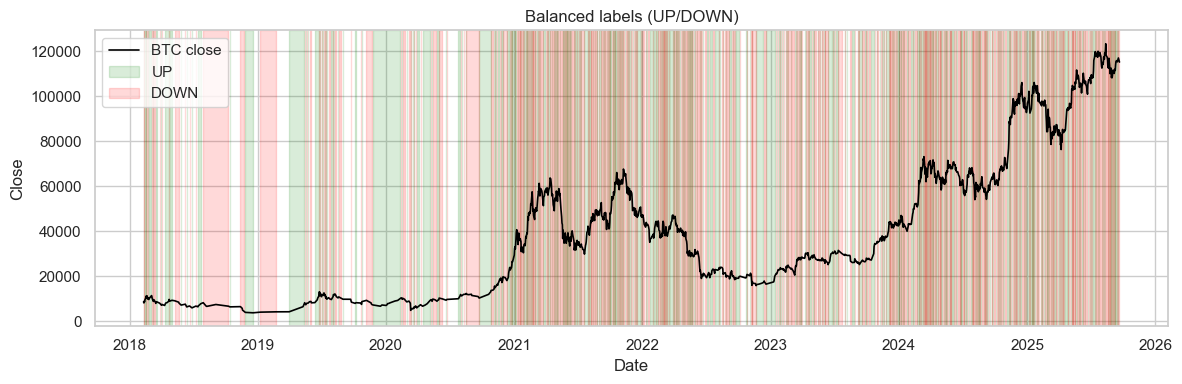


[CELL] Cell 11
Purpose: Simple label plot (binary)
Notes:
- Oracle labels (targets) for training/eval.
Variables used in this cell:
  PLOT_PRICE_MODE = 'raw'
  ax = <Axes: title={'center': 'Balanced labels (UP/DOWN)'}, xlabel='Date', ylabel='Close'>
  close = ndarray shape=(1390,) dtype=float64 sample=[8559.6 8081.9 8903.5 8539.2 9476.3]
  dates = ndarray shape=(1390,) dtype=datetime64[ns] sample=['2018-02-10T00:00:00.000000000' '2018-02-11T00:00:00.000000000'
 '2018-02-12T00:00:00.000000000' '2018-02-13T00:00:00.000000000'
 '2018-02-14T00:00:00.000000000']
  df_labels (oracle labels table) = DataFrame shape=(1390, 3) cols_count=3 cols_preview=['date', 'close', 'target'] head=
        date   close  target
0 2018-02-10  8559.6       0
1 2018-02-11  8081.9       1
2 2018-02-12  8903.5       0
  down_mask = ndarray shape=(1390,) dtype=bool sample=[ True False  True False False]
  labels = ndarray shape=(1390,) dtype=int64 sample=[0 1 0 1 1]
  np = <module numpy>
  pd = <module pandas>
  

In [9]:

# Simple label plot (binary)
plot_df = df_labels[['date', 'close', 'target']].copy()
plot_df['date'] = pd.to_datetime(plot_df['date'])
plot_df = plot_df.sort_values('date').reset_index(drop=True)

def shade_up_down(ax, dates, close, up_mask, down_mask, title: str, y_label: str):
    ax.plot(dates, close, color='black', linewidth=1.2, label='BTC close')
    ax.fill_between(dates, 0, 1, where=up_mask, transform=ax.get_xaxis_transform(),
                   color='green', alpha=0.15, label='UP')
    ax.fill_between(dates, 0, 1, where=down_mask, transform=ax.get_xaxis_transform(),
                   color='red', alpha=0.15, label='DOWN')
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.legend(loc='upper left')

labels = plot_df['target'].to_numpy()
up_mask = labels == 1
down_mask = labels == 0

dates = plot_df['date'].to_numpy()
if PLOT_PRICE_MODE == 'log':
    close = np.log(plot_df['close'].to_numpy())
    y_label = 'log(price)'
else:
    close = plot_df['close'].to_numpy()
    y_label = 'Close'

fig, ax = plt.subplots(figsize=(12, 4))
shade_up_down(ax, dates, close, up_mask, down_mask, 'Balanced labels (UP/DOWN)', y_label)
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()




trace_cell(
    title='Cell 11',
    purpose='Simple label plot (binary)',
    used_vars=['PLOT_PRICE_MODE', 'ax', 'close', 'dates', 'df_labels', 'down_mask', 'labels', 'np', 'pd', 'plot_df', 'plt', 'shade_up_down', 'up_mask', 'y_label'],
    notes=['Oracle labels (targets) for training/eval.'],
    show_missing=False,
)


## 2. Target shift by horizon


In [10]:

# Target already includes horizon (future return), no additional shift needed
df_labels_shifted = df_labels.copy()
df_labels_shifted = df_labels_shifted.dropna(subset=['target']).reset_index(drop=True)
df_labels_shifted['target'] = df_labels_shifted['target'].astype(int)

print(df_labels_shifted[['date', 'target']].tail())
print(f'Rows after labeling: {len(df_labels_shifted)}')




trace_cell(
    title='Cell 13',
    purpose='Target already includes horizon (future return), no additional shift needed',
    used_vars=['df_labels', 'df_labels_shifted'],
    notes=['Oracle labels (targets) for training/eval.'],
    show_missing=False,
)


           date  target
1385 2025-09-13       0
1386 2025-09-15       1
1387 2025-09-17       1
1388 2025-09-18       0
1389 2025-09-21       0
Rows after labeling: 1390

[CELL] Cell 13
Purpose: Target already includes horizon (future return), no additional shift needed
Notes:
- Oracle labels (targets) for training/eval.
Variables used in this cell:
  df_labels (oracle labels table) = DataFrame shape=(1390, 3) cols_count=3 cols_preview=['date', 'close', 'target'] head=
        date   close  target
0 2018-02-10  8559.6       0
1 2018-02-11  8081.9       1
2 2018-02-12  8903.5       0
  df_labels_shifted = DataFrame shape=(1390, 3) cols_count=3 cols_preview=['date', 'close', 'target'] head=
        date   close  target
0 2018-02-10  8559.6       0
1 2018-02-11  8081.9       1
2 2018-02-12  8903.5       0


## 3. Astro data and astro features


In [11]:
from datetime import datetime, timezone
from tqdm import tqdm

from src.astro.engine.settings import AstroSettings
from src.astro.engine.calculator import set_ephe_path, calculate_daily_bodies, calculate_bodies
from src.astro.engine.aspects import calculate_aspects, calculate_transit_aspects
from src.astro.engine.models import AspectConfig
from src.features.builder import build_features_daily


def _parse_birth_dt_utc(value: str) -> datetime:
    s = value.strip()
    if s.endswith('Z'):
        s = s[:-1] + '+00:00'
    dt = datetime.fromisoformat(s)
    if dt.tzinfo is None:
        dt = dt.replace(tzinfo=timezone.utc)
    return dt.astimezone(timezone.utc)


# Astro settings
astro_cfg = cfg_astro["astro"]
# Same path rules: resolve to PROJECT_ROOT
_ephe_path = _resolve_path(astro_cfg["ephe_path"])
set_ephe_path(str(_ephe_path))

settings = AstroSettings(
    bodies_path=_resolve_path(astro_cfg["bodies_path"]),
    aspects_path=_resolve_path(astro_cfg["aspects_path"]),
)

time_utc = datetime.strptime(astro_cfg["daily_time_utc"], "%H:%M:%S").time()
center = astro_cfg.get("center", "geo")

include_pair_aspects = bool(astro_cfg.get("include_pair_aspects", True))
include_transit_aspects = bool(astro_cfg.get("include_transit_aspects", False))

bodies_path = processed_dir / f"{subject.subject_id}_astro_bodies.parquet"
aspects_path = processed_dir / f"{subject.subject_id}_astro_aspects.parquet"
transits_path = processed_dir / f"{subject.subject_id}_transit_aspects.parquet"
features_path = processed_dir / f"{subject.subject_id}_features.parquet"

# Orb multiplier (1.0 = default orbs from aspects.yaml)
ORB_MULTIPLIER = 1.0

natal_bodies = None
if include_transit_aspects:
    birth_dt = _parse_birth_dt_utc(subject.birth_dt_utc)
    natal_bodies = calculate_bodies(birth_dt, settings.bodies, center=center)

# Ignore astro cache, recompute
print("Ignoring astro cache, recomputing bodies...")
bodies_rows = []
bodies_by_date = {}
dates = pd.to_datetime(df_market["date"]).dt.date

for d in tqdm(dates, desc="astro days"):
    bodies = calculate_daily_bodies(d, time_utc, settings.bodies, center=center)
    bodies_by_date[d] = bodies

    for b in bodies:
        bodies_rows.append({
            "date": b.date,
            "body": b.body,
            "lon": b.lon,
            "lat": b.lat,
            "speed": b.speed,
            "is_retro": b.is_retro,
            "sign": b.sign,
            "declination": b.declination,
        })

df_bodies = pd.DataFrame(bodies_rows)


def _scale_aspects(aspects, orb_mult: float):
    scaled = []
    for a in aspects:
        scaled.append(AspectConfig(name=a.name, degree=a.degree, orb=float(a.orb) * float(orb_mult)))
    return scaled


def build_aspects_df_for_orb(orb_mult: float):
    aspects_rows = []
    aspects_cfg = _scale_aspects(settings.aspects, orb_mult)
    for d, bodies in bodies_by_date.items():
        aspects = calculate_aspects(bodies, aspects_cfg)
        for a in aspects:
            aspects_rows.append({
                "date": a.date,
                "p1": a.p1,
                "p2": a.p2,
                "aspect": a.aspect,
                "orb": a.orb,
                "is_exact": a.is_exact,
                "is_applying": a.is_applying,
            })
    return pd.DataFrame(aspects_rows)


if include_pair_aspects:
    print(f"Computing aspects with ORB_MULTIPLIER={ORB_MULTIPLIER}")
    df_aspects = build_aspects_df_for_orb(ORB_MULTIPLIER)
else:
    print("Skipping transit-transit aspects (include_pair_aspects=False)")
    df_aspects = pd.DataFrame(columns=["date", "p1", "p2", "aspect", "orb", "is_exact", "is_applying"])

# Transit->natal aspects (optional)
df_transits = None
if include_transit_aspects:
    print(f"Computing transit->natal aspects with ORB_MULTIPLIER={ORB_MULTIPLIER}")
    transit_rows = []
    aspects_cfg = _scale_aspects(settings.aspects, ORB_MULTIPLIER)
    for d, bodies in bodies_by_date.items():
        hits = calculate_transit_aspects(bodies, natal_bodies, aspects_cfg)
        for h in hits:
            transit_rows.append({
                "date": h.date,
                "transit_body": h.transit_body,
                "natal_body": h.natal_body,
                "aspect": h.aspect,
                "orb": h.orb,
                "is_exact": h.is_exact,
                "is_applying": h.is_applying,
            })
    df_transits = pd.DataFrame(transit_rows)

bodies_path.parent.mkdir(parents=True, exist_ok=True)
df_bodies.to_parquet(bodies_path, index=False)
if include_pair_aspects:
    df_aspects.to_parquet(aspects_path, index=False)
if include_transit_aspects and df_transits is not None:
    df_transits.to_parquet(transits_path, index=False)

print(f"Saved bodies: {bodies_path}")
if include_pair_aspects:
    print(f"Saved aspects: {aspects_path}")
if include_transit_aspects:
    print(f"Saved transits: {transits_path}")

print(df_bodies.head())
print(df_aspects.head())
if include_transit_aspects and df_transits is not None:
    print(df_transits.head())

trace_cell(
    title='Cell 15',
    used_vars=['AstroSettings', 'ORB_MULTIPLIER', '_ephe_path', '_resolve_path', 'aspects_path', 'astro_cfg', 'b', 'bodies', 'bodies_by_date', 'bodies_path', 'bodies_rows', 'build_aspects_df_for_orb', 'calculate_daily_bodies', 'calculate_bodies', 'calculate_aspects', 'calculate_transit_aspects', 'center', 'cfg_astro', 'd', 'dates', 'datetime', 'df_aspects', 'df_bodies', 'df_market', 'df_transits', 'include_pair_aspects', 'include_transit_aspects', 'pd', 'processed_dir', 'set_ephe_path', 'settings', 'subject', 'time_utc', 'tqdm'],
    notes=['Uses astro config (bodies/aspects paths, ephemeris path, center).', 'Center controls geo vs helio coordinates for astro bodies/aspects.', 'Market dataframe is the price source for labels/plots.'],
    show_missing=False,
)



Ignoring astro cache, recomputing bodies...


astro days: 100%|███████████████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 6830.09it/s]


Computing aspects with ORB_MULTIPLIER=1.0
Saved bodies: C:\_PYTH\projects\PythonProject\ostrofun\data\market\processed\btc_astro_bodies.parquet
Saved aspects: C:\_PYTH\projects\PythonProject\ostrofun\data\market\processed\btc_astro_aspects.parquet
         date     body         lon       lat      speed  is_retro     sign  declination
0  2017-11-01      Sun  218.755657 -0.000011   1.000008     False  Scorpio    -0.000011
1  2017-11-01     Moon  356.209228 -2.907350  13.493332     False   Pisces    -2.907350
2  2017-11-01  Mercury  232.905646 -1.409936   1.497015     False  Scorpio    -1.409936
3  2017-11-01    Venus  201.888931  1.488282   1.249436     False    Libra     1.488282
4  2017-11-01     Mars  185.828074  1.137132   0.631064     False    Libra     1.137132
         date    p1       p2       aspect       orb  is_exact  is_applying
0  2017-11-01   Sun  Jupiter  Conjunction  4.092977     False        False
1  2017-11-01   Sun  Neptune        Trine  2.840517     False         True

In [12]:
# Build astro features
# Ignore features cache, recompute
print("Ignoring features cache, recomputing...")
df_features = build_features_daily(
    df_bodies,
    df_aspects,
    df_transits if include_transit_aspects else None,
    include_pair_aspects=include_pair_aspects,
    include_transit_aspects=include_transit_aspects,
)
df_features.to_parquet(features_path, index=False)
print(f"Saved features: {features_path}")

print(df_features.head())
print(f"Features: {df_features.shape}")




trace_cell(
    title='Cell 16',
    purpose='Build astro features',
    used_vars=['build_features_daily', 'df_aspects', 'df_bodies', 'df_features', 'df_transits', 'features_path', 'include_pair_aspects', 'include_transit_aspects'],
    notes=['Feature matrix used for XGBoost training.'],
    show_missing=False,
)



Ignoring features cache, recomputing...
Saved features: C:\_PYTH\projects\PythonProject\ostrofun\data\market\processed\btc_features.parquet
         date  Jupiter_lon  Lilith_lon    Mars_lon  MeanNode_lon  Mercury_lon    Moon_lon  Neptune_lon   Pluto_lon  Saturn_lon     Sun_lon  TrueNode_lon  Uranus_lon   Venus_lon  Jupiter_speed  \
0  2017-11-01   214.662680  269.089371  185.828074    140.126691   232.905646  356.209228   341.596174  287.127692  264.609855  218.755657    141.000541   26.027296  201.888931       0.218073   
1  2017-11-02   214.880702  269.200882  186.459109    140.073706   234.398481    9.936665   341.584602  287.144191  264.703843  219.755898    140.886151   25.987864  203.138561       0.217967   
2  2017-11-03   215.098611  269.312392  187.090093    140.020725   235.882907   24.114155   341.573540  287.161145  264.798752  220.756617    140.729548   25.948669  204.388586       0.217850   
3  2017-11-04   215.316399  269.423908  187.721044    139.967753   237.358797   

In [83]:
# GRID SEARCH: orbs + gaussian (binary, on-the-fly astro)
# Self-contained: loads configs/market if missing, computes bodies if missing.
import sys
from pathlib import Path
from datetime import datetime, time, timezone
import numpy as np
import pandas as pd

try:
    from tqdm import tqdm
except Exception:
    tqdm = None

try:
    from IPython.display import display
except Exception:
    display = print

# Ensure project root (find configs/market.yaml)
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / 'configs/market.yaml').exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / 'configs/market.yaml').exists():
            PROJECT_ROOT = parent
            break
if not (PROJECT_ROOT / 'configs/market.yaml').exists():
    raise FileNotFoundError('Project root not found: configs/market.yaml')
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.common.config import load_yaml, load_subjects
from src.market.loader import load_market_daily_parquet, load_market_daily_psql, load_market_daily_csv
from src.astro.engine.settings import AstroSettings
from src.astro.engine.calculator import set_ephe_path, calculate_daily_bodies, calculate_bodies
from src.astro.engine.aspects import calculate_aspects, calculate_transit_aspects
from src.astro.engine.models import AspectConfig
from src.features.builder import build_features_daily
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report
from src.models.xgb import XGBBaseline

# Ensure device is defined for grid search
device = globals().get('device', 'cpu')

def _iter(items, desc):
    if tqdm is None:
        return items
    return tqdm(items, desc=desc, unit='step')

def _parse_time_utc(value: str) -> time:
    return datetime.strptime(value, '%H:%M:%S').time()

def _parse_birth_dt_utc(value: str) -> datetime:
    s = value.strip()
    if s.endswith('Z'):
        s = s[:-1] + '+00:00'
    dt = datetime.fromisoformat(s)
    if dt.tzinfo is None:
        dt = dt.replace(tzinfo=timezone.utc)
    return dt.astimezone(timezone.utc)

# --- Load configs if missing ---
if 'cfg_market' not in globals():
    cfg_market = load_yaml(PROJECT_ROOT / 'configs/market.yaml')
if 'cfg_astro' not in globals():
    cfg_astro = load_yaml(PROJECT_ROOT / 'configs/astro.yaml')
if 'cfg_labels' not in globals():
    cfg_labels = load_yaml(PROJECT_ROOT / 'configs/labels.yaml')
if 'cfg_db' not in globals():
    try:
        cfg_db = load_yaml(PROJECT_ROOT / 'configs/db.yaml')
    except Exception:
        cfg_db = {'db': {}}

subjects, active_id = load_subjects(PROJECT_ROOT / 'configs/subjects.yaml')
subject = subjects[active_id]

# --- Load market data (no download here) ---
if 'df_market' not in globals():
    market_cfg = cfg_market['market']
    data_root = PROJECT_ROOT / market_cfg['data_root']
    processed_dir = data_root / 'processed'
    market_parquet = processed_dir / f"{subject.subject_id}_market_daily.parquet"
    market_csv = processed_dir / f"{subject.subject_id}_market_daily.csv"
    df_db = None
    if market_cfg.get('use_db_cache', False):
        db_url = (cfg_db.get('db') or {}).get('url', '')
        if db_url:
            try:
                df_db = load_market_daily_psql(subject.subject_id, db_url)
            except Exception as e:
                print(f'[WARN] DB cache failed: {e}')
                df_db = None
    df_parq = None
    if market_cfg.get('use_parquet_cache', True) and market_parquet.exists():
        try:
            df_parq = load_market_daily_parquet(market_parquet)
        except Exception as e:
            print(f'[WARN] Parquet load failed: {e}')
            df_parq = None
    if df_parq is None and market_csv.exists():
        try:
            df_parq = load_market_daily_csv(market_csv)
        except Exception as e:
            print(f'[WARN] CSV load failed: {e}')
            df_parq = None
    frames = []
    if df_db is not None and not df_db.empty:
        df_db = df_db.copy()
        df_db['date'] = pd.to_datetime(df_db['date'])
        frames.append(df_db)
    if df_parq is not None and not df_parq.empty:
        df_parq = df_parq.copy()
        df_parq['date'] = pd.to_datetime(df_parq['date'])
        frames.append(df_parq)
    if not frames:
        raise RuntimeError('Market data not found in DB/parquet/CSV. Run downloader/parser first.')
    if len(frames) == 1:
        df_market = frames[0]
    else:
        df_market = pd.concat(frames, ignore_index=True)
        df_market = df_market.drop_duplicates(subset=['date'], keep='last')

df_market = df_market.copy()
df_market['date'] = pd.to_datetime(df_market['date'])
df_market = df_market.sort_values('date').reset_index(drop=True)
df_market = df_market[df_market['date'] >= pd.Timestamp('2017-11-01')].reset_index(drop=True)
if 'close' not in df_market.columns:
    raise KeyError('df_market must contain close column')

# --- Labeling parameters (defaults from config) ---
labels_cfg = cfg_labels['labels']
LABEL_PRICE_MODE = str(globals().get('LABEL_PRICE_MODE', labels_cfg.get('price_mode', 'raw'))).lower()
HORIZON = int(globals().get('HORIZON', labels_cfg.get('horizon', 1)))
TARGET_MOVE_SHARE = float(globals().get('TARGET_MOVE_SHARE', labels_cfg.get('target_move_share', 0.5)))
MOVE_SHARE_TOTAL = float(globals().get('MOVE_SHARE_TOTAL', TARGET_MOVE_SHARE))

# --- Astro settings and bodies ---
astro_cfg = cfg_astro['astro']
ephe_path = Path(astro_cfg['ephe_path'])
if not ephe_path.is_absolute():
    ephe_path = PROJECT_ROOT / ephe_path
set_ephe_path(str(ephe_path))
bodies_path = Path(astro_cfg['bodies_path'])
aspects_path = Path(astro_cfg['aspects_path'])
if not bodies_path.is_absolute():
    bodies_path = PROJECT_ROOT / bodies_path
if not aspects_path.is_absolute():
    aspects_path = PROJECT_ROOT / aspects_path
settings = AstroSettings(bodies_path=bodies_path, aspects_path=aspects_path)
time_utc = _parse_time_utc(astro_cfg['daily_time_utc'])
center = astro_cfg.get('center', 'geo')

INCLUDE_PAIR_ASPECTS = bool(astro_cfg.get('include_pair_aspects', True))
INCLUDE_TRANSIT_ASPECTS = bool(astro_cfg.get('include_transit_aspects', False))

natal_bodies = None
if INCLUDE_TRANSIT_ASPECTS:
    birth_dt = _parse_birth_dt_utc(subject.birth_dt_utc)
    natal_bodies = calculate_bodies(birth_dt, settings.bodies, center=center)

# --- Bodies cache ---
dates = pd.to_datetime(df_market['date']).dt.date
# Validate existing bodies_by_date; if invalid or missing, recompute bodies
_valid_bodies_by_date = False
if 'bodies_by_date' in globals():
    try:
        if isinstance(bodies_by_date, list) and len(bodies_by_date) > 0:
            first = bodies_by_date[0]
            if isinstance(first, (list, tuple)) and len(first) > 0 and hasattr(first[0], 'lon'):
                _valid_bodies_by_date = True
    except Exception:
        _valid_bodies_by_date = False

if 'df_bodies' not in globals() or not _valid_bodies_by_date:
    bodies_rows = []
    bodies_by_date = []
    for d in _iter(dates, desc='astro bodies'):
        bodies = calculate_daily_bodies(d, time_utc, settings.bodies, center=center)
        bodies_by_date.append(bodies)
        for b in bodies:
            bodies_rows.append({
                'date': b.date,
                'body': b.body,
                'lon': b.lon,
                'lat': b.lat,
                'speed': b.speed,
                'is_retro': b.is_retro,
                'sign': b.sign,
                'declination': b.declination,
            })
    df_bodies = pd.DataFrame(bodies_rows)
    _valid_bodies_by_date = True


def _gaussian_kernel(window: int, std: float) -> np.ndarray:
    if window % 2 == 0:
        window += 1
    half = window // 2
    x = np.arange(-half, half + 1, dtype=float)
    kernel = np.exp(-0.5 * (x / std) ** 2)
    kernel = kernel / kernel.sum()
    return kernel


def _gaussian_smooth_centered(series: pd.Series, window: int, std: float) -> pd.Series:
    if series.empty:
        return series.copy()
    kernel = _gaussian_kernel(window, std)
    pad = len(kernel) // 2
    arr = series.values.astype(float)
    left = np.full(pad, arr[0])
    right = np.full(pad, arr[-1])
    padded = np.concatenate([left, arr, right])
    smooth = np.convolve(padded, kernel, mode='valid')
    return pd.Series(smooth, index=series.index)


def _scale_aspects(aspects, orb_mult: float):
    scaled = []
    for a in aspects:
        scaled.append(AspectConfig(name=a.name, degree=a.degree, orb=float(a.orb) * float(orb_mult)))
    return scaled


def build_aspects_df_for_orb(orb_mult: float):
    aspects_scaled = _scale_aspects(settings.aspects, orb_mult)
    rows = []
    source_iter = bodies_by_date if _valid_bodies_by_date else dates
    for item in _iter(source_iter, desc=f'aspects orb={orb_mult}'):
        if isinstance(item, (list, tuple)):
            bodies = item
        else:
            bodies = calculate_daily_bodies(item, time_utc, settings.bodies, center=center)
        aspects = calculate_aspects(bodies, aspects_scaled)
        for a in aspects:
            rows.append({
                'date': a.date,
                'p1': a.p1,
                'p2': a.p2,
                'aspect': a.aspect,
                'orb': a.orb,
                'is_exact': a.is_exact,
                'is_applying': a.is_applying,
            })
    return pd.DataFrame(rows)


def build_transit_df_for_orb(orb_mult: float):
    if not INCLUDE_TRANSIT_ASPECTS:
        return pd.DataFrame(columns=['date', 'transit_body', 'natal_body', 'aspect', 'orb', 'is_exact', 'is_applying'])
    if natal_bodies is None:
        raise RuntimeError('INCLUDE_TRANSIT_ASPECTS=True but natal_bodies is None')
    aspects_scaled = _scale_aspects(settings.aspects, orb_mult)
    rows = []
    source_iter = bodies_by_date if _valid_bodies_by_date else dates
    for item in _iter(source_iter, desc=f'transits orb={orb_mult}'):
        if isinstance(item, (list, tuple)):
            bodies = item
        else:
            bodies = calculate_daily_bodies(item, time_utc, settings.bodies, center=center)
        hits = calculate_transit_aspects(bodies, natal_bodies, aspects_scaled)
        for h in hits:
            rows.append({
                'date': h.date,
                'transit_body': h.transit_body,
                'natal_body': h.natal_body,
                'aspect': h.aspect,
                'orb': h.orb,
                'is_exact': h.is_exact,
                'is_applying': h.is_applying,
            })
    return pd.DataFrame(rows)


# --- GRID SEARCH PARAMS ---
GRID_ORB_MULTIPLIERS = [0.8, 1.0, 1.2]
GRID_GAUSS_WINDOWS = [101, 151, 201]
GRID_GAUSS_STDS = [30.0, 50.0, 70.0]
GRID_MAX_COMBOS = None  # e.g. 10 to stop early

GRID_MODEL_PARAMS = dict(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
)


def make_labels_gauss(gauss_window: int, gauss_std: float):
    if LABEL_PRICE_MODE == 'log':
        base_series = np.log(df_market['close']).astype(float)
    else:
        base_series = df_market['close'].astype(float)

    smooth = _gaussian_smooth_centered(base_series, int(gauss_window), float(gauss_std))
    base = base_series - smooth
    future_ret = base.shift(-HORIZON) - base

    valid = future_ret.dropna()
    total_n = len(valid)
    if total_n == 0:
        raise ValueError('No valid future returns for labeling')

    per_side = max(1, int(total_n * MOVE_SHARE_TOTAL / 2))
    pos = valid[valid > 0]
    neg = valid[valid < 0]
    n_up = min(per_side, len(pos))
    n_down = min(per_side, len(neg))

    up_idx = pos.nlargest(n_up).index
    down_idx = neg.nsmallest(n_down).index

    df_labels_local = df_market.copy()
    df_labels_local['target'] = np.nan
    df_labels_local.loc[up_idx, 'target'] = 1
    df_labels_local.loc[down_idx, 'target'] = 0

    df_labels_local = df_labels_local.dropna(subset=['target']).reset_index(drop=True)
    df_labels_local['target'] = df_labels_local['target'].astype(int)
    return df_labels_local


def build_dataset_for_combo(orb_mult: float, gauss_window: int, gauss_std: float):
    df_aspects_local = build_aspects_df_for_orb(orb_mult)
    df_transits_local = build_transit_df_for_orb(orb_mult) if INCLUDE_TRANSIT_ASPECTS else None
    df_features_local = build_features_daily(
        df_bodies,
        df_aspects_local,
        df_transits_local,
        include_pair_aspects=INCLUDE_PAIR_ASPECTS,
        include_transit_aspects=INCLUDE_TRANSIT_ASPECTS,
    )
    df_labels_local = make_labels_gauss(gauss_window, gauss_std)

    df_features_local['date'] = pd.to_datetime(df_features_local['date'])
    df_labels_local['date'] = pd.to_datetime(df_labels_local['date'])

    df_dataset_local = pd.merge(df_labels_local[['date', 'target']], df_features_local, on='date', how='inner')
    df_dataset_local = df_dataset_local.sort_values('date').reset_index(drop=True)
    return df_dataset_local


def split_dataset(df_dataset_local, train_ratio=0.7, val_ratio=0.15):
    n = len(df_dataset_local)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    train_df = df_dataset_local.iloc[:train_end].copy()
    val_df = df_dataset_local.iloc[train_end:val_end].copy()
    test_df = df_dataset_local.iloc[val_end:].copy()
    return train_df, val_df, test_df


def eval_combo(orb_mult, gauss_window, gauss_std):
    df_dataset_local = build_dataset_for_combo(orb_mult, gauss_window, gauss_std)
    train_df, val_df, test_df = split_dataset(df_dataset_local)

    feature_cols_local = [c for c in df_dataset_local.columns if c not in ['date', 'target']]
    X_train = train_df[feature_cols_local].values
    y_train = train_df['target'].values
    X_val = val_df[feature_cols_local].values
    y_val = val_df['target'].values
    X_test = test_df[feature_cols_local].values
    y_test = test_df['target'].values

    w_train = compute_sample_weight(class_weight='balanced', y=y_train)
    w_val = compute_sample_weight(class_weight='balanced', y=y_val)

    model = XGBBaseline(
        n_classes=2,
        device=device,
        random_state=42,
        **GRID_MODEL_PARAMS,
    )
    model.fit(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        feature_names=feature_cols_local,
        sample_weight=w_train,
        sample_weight_val=w_val,
    )

    # threshold tuning on val for balanced F1
    X_val_scaled = model.scaler.transform(X_val)
    proba_val = model.model.predict_proba(X_val_scaled)[:, 1]
    thresholds = np.linspace(0.05, 0.95, 91)
    best_t = 0.5
    best_score = -1.0
    for t in thresholds:
        pred_val = (proba_val >= t).astype(np.int32)
        report = classification_report(
            y_val, pred_val, labels=[0, 1],
            target_names=['DOWN', 'UP'], output_dict=True, zero_division=0
        )
        f1_down = report['DOWN']['f1-score']
        f1_up = report['UP']['f1-score']
        score = min(f1_down, f1_up)
        if score > best_score:
            best_score = score
            best_t = float(t)

    X_test_scaled = model.scaler.transform(X_test)
    proba_test = model.model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (proba_test >= best_t).astype(np.int32)
    report_test = classification_report(
        y_test, y_pred, labels=[0, 1],
        target_names=['DOWN', 'UP'], output_dict=True, zero_division=0
    )

    return {
        'orb_mult': orb_mult,
        'gauss_window': gauss_window,
        'gauss_std': gauss_std,
        'threshold': best_t,
        'f1_down': report_test['DOWN']['f1-score'],
        'f1_up': report_test['UP']['f1-score'],
        'f1_min': min(report_test['DOWN']['f1-score'], report_test['UP']['f1-score']),
        'f1_macro': report_test['macro avg']['f1-score'],
    }


results = []
combo_count = 0
for orb_mult in GRID_ORB_MULTIPLIERS:
    for gw in GRID_GAUSS_WINDOWS:
        for gs in GRID_GAUSS_STDS:
            combo_count += 1
            if GRID_MAX_COMBOS and combo_count > GRID_MAX_COMBOS:
                break
            print(f'Combo {combo_count}: orb_mult={orb_mult}, gauss_window={gw}, gauss_std={gs}')
            res = eval_combo(orb_mult, gw, gs)
            results.append(res)
        if GRID_MAX_COMBOS and combo_count > GRID_MAX_COMBOS:
            break
    if GRID_MAX_COMBOS and combo_count > GRID_MAX_COMBOS:
        break

results_df = pd.DataFrame(results)
# Balance score: minimize f1 gap, then maximize f1_min and f1_macro
results_df['f1_gap'] = (results_df['f1_down'] - results_df['f1_up']).abs()
results_df = results_df.sort_values(['f1_gap', 'f1_min', 'f1_macro'], ascending=[True, False, False]).reset_index(drop=True)
print('Top combos by balance (min f1_gap):')
display(results_df.head(10))

GRID_APPLY_BEST = True
GRID_WRITE_PARQUET = False  # set True if you want to save features/aspects to disk

if GRID_APPLY_BEST and not results_df.empty:
    best = results_df.iloc[0].to_dict()
    ORB_MULTIPLIER = float(best['orb_mult'])
    GAUSS_WINDOW = int(best['gauss_window'])
    GAUSS_STD = float(best['gauss_std'])
    GRID_BEST_THRESHOLD = float(best['threshold'])
    print(
        f"[AUTO] Best balanced combo -> orb_mult={ORB_MULTIPLIER}, gauss_window={GAUSS_WINDOW}, gauss_std={GAUSS_STD}, "
        f"threshold={GRID_BEST_THRESHOLD:.2f}, f1_down={best['f1_down']:.3f}, f1_up={best['f1_up']:.3f}, gap={best['f1_gap']:.3f}"
    )

    # Recompute aspects/features/labels using best combo
    df_aspects = build_aspects_df_for_orb(ORB_MULTIPLIER)
    df_transits = build_transit_df_for_orb(ORB_MULTIPLIER) if INCLUDE_TRANSIT_ASPECTS else None
    df_features = build_features_daily(
        df_bodies,
        df_aspects,
        df_transits,
        include_pair_aspects=INCLUDE_PAIR_ASPECTS,
        include_transit_aspects=INCLUDE_TRANSIT_ASPECTS,
    )
    df_labels = make_labels_gauss(GAUSS_WINDOW, GAUSS_STD)

    # Match downstream expectations
    df_labels_shifted = df_labels.copy()
    df_labels_shifted = df_labels_shifted.dropna(subset=['target']).reset_index(drop=True)
    df_labels_shifted['target'] = df_labels_shifted['target'].astype(int)

    if GRID_WRITE_PARQUET:
        try:
            data_root = PROJECT_ROOT / cfg_market['market']['data_root']
            processed_dir = data_root / 'processed'
            processed_dir.mkdir(parents=True, exist_ok=True)
            df_bodies.to_parquet(processed_dir / f"{subject.subject_id}_astro_bodies.parquet", index=False)
            df_aspects.to_parquet(processed_dir / f"{subject.subject_id}_astro_aspects.parquet", index=False)
            if INCLUDE_TRANSIT_ASPECTS and df_transits is not None:
                df_transits.to_parquet(processed_dir / f"{subject.subject_id}_transit_aspects.parquet", index=False)
            df_features.to_parquet(processed_dir / f"{subject.subject_id}_features.parquet", index=False)
        except Exception as e:
            print(f"[WARN] Failed to save parquet: {e}")

if 'trace_cell' in globals():
    trace_cell(
        title='Grid Search',
        purpose='GRID SEARCH: orbs + gaussian (binary, on-the-fly astro)',
        show_missing=False,
    )



Combo 1: orb_mult=0.8, gauss_window=101, gauss_std=30.0


aspects orb=0.8: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 11687.95step/s]


Combo 2: orb_mult=0.8, gauss_window=101, gauss_std=50.0


aspects orb=0.8: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 18546.30step/s]


Combo 3: orb_mult=0.8, gauss_window=101, gauss_std=70.0


aspects orb=0.8: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 18405.38step/s]


Combo 4: orb_mult=0.8, gauss_window=151, gauss_std=30.0


aspects orb=0.8: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 17719.84step/s]


Combo 5: orb_mult=0.8, gauss_window=151, gauss_std=50.0


aspects orb=0.8: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 17755.22step/s]


Combo 6: orb_mult=0.8, gauss_window=151, gauss_std=70.0


aspects orb=0.8: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 17853.58step/s]


Combo 7: orb_mult=0.8, gauss_window=201, gauss_std=30.0


aspects orb=0.8: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 18970.75step/s]


Combo 8: orb_mult=0.8, gauss_window=201, gauss_std=50.0


aspects orb=0.8: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 17633.48step/s]


Combo 9: orb_mult=0.8, gauss_window=201, gauss_std=70.0


aspects orb=0.8: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 18577.11step/s]


Combo 10: orb_mult=1.0, gauss_window=101, gauss_std=30.0


aspects orb=1.0: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 16599.99step/s]


Combo 11: orb_mult=1.0, gauss_window=101, gauss_std=50.0


aspects orb=1.0: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 16690.74step/s]


Combo 12: orb_mult=1.0, gauss_window=101, gauss_std=70.0


aspects orb=1.0: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 17428.77step/s]


Combo 13: orb_mult=1.0, gauss_window=151, gauss_std=30.0


aspects orb=1.0: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 15397.97step/s]


Combo 14: orb_mult=1.0, gauss_window=151, gauss_std=50.0


aspects orb=1.0: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 16843.57step/s]


Combo 15: orb_mult=1.0, gauss_window=151, gauss_std=70.0


aspects orb=1.0: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 16757.28step/s]


Combo 16: orb_mult=1.0, gauss_window=201, gauss_std=30.0


aspects orb=1.0: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 16263.73step/s]


Combo 17: orb_mult=1.0, gauss_window=201, gauss_std=50.0


aspects orb=1.0: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 15596.54step/s]


Combo 18: orb_mult=1.0, gauss_window=201, gauss_std=70.0


aspects orb=1.0: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 15827.14step/s]


Combo 19: orb_mult=1.2, gauss_window=101, gauss_std=30.0


aspects orb=1.2: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 16196.53step/s]


Combo 20: orb_mult=1.2, gauss_window=101, gauss_std=50.0


aspects orb=1.2: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 15952.95step/s]


Combo 21: orb_mult=1.2, gauss_window=101, gauss_std=70.0


aspects orb=1.2: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 15842.95step/s]


Combo 22: orb_mult=1.2, gauss_window=151, gauss_std=30.0


aspects orb=1.2: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 15462.37step/s]


Combo 23: orb_mult=1.2, gauss_window=151, gauss_std=50.0


aspects orb=1.2: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 15639.65step/s]


Combo 24: orb_mult=1.2, gauss_window=151, gauss_std=70.0


aspects orb=1.2: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 15632.09step/s]


Combo 25: orb_mult=1.2, gauss_window=201, gauss_std=30.0


aspects orb=1.2: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 16203.41step/s]


Combo 26: orb_mult=1.2, gauss_window=201, gauss_std=50.0


aspects orb=1.2: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 15613.11step/s]


Combo 27: orb_mult=1.2, gauss_window=201, gauss_std=70.0


aspects orb=1.2: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 15895.65step/s]


Top combos by balance (min f1_gap):


,orb_mult,gauss_window,gauss_std,threshold,f1_down,f1_up,f1_min,f1_macro,f1_gap
0,0.8,201,70.0,0.48,0.556054,0.560000,0.556054,0.558027,0.003946
1,1.0,101,70.0,0.50,0.513514,0.522124,0.513514,0.517819,0.008610
2,1.0,101,30.0,0.51,0.542986,0.555066,0.542986,0.549026,0.012080
3,0.8,101,70.0,0.46,0.570093,0.606838,0.570093,0.588466,0.036744
4,1.0,101,50.0,0.46,0.542056,0.581197,0.542056,0.561626,0.039141
5,0.8,201,30.0,0.47,0.572770,0.612766,0.572770,0.592768,0.039996
6,1.0,151,30.0,0.51,0.544601,0.587234,0.544601,0.565917,0.042633
7,1.0,201,70.0,0.47,0.566038,0.610169,0.566038,0.588104,0.044132
8,0.8,201,50.0,0.46,0.556604,0.601695,0.556604,0.579149,0.045091
9,1.0,151,50.0,0.48,0.584746,0.537736,0.537736,0.561241,0.047010


[AUTO] Best balanced combo -> orb_mult=0.8, gauss_window=201, gauss_std=70.0, threshold=0.48, f1_down=0.556, f1_up=0.560, gap=0.004


aspects orb=0.8: 100%|███████████████████████████████████████████████████████████████████████████| 2983/2983 [00:00<00:00, 18708.02step/s]



[CELL] Grid Search
Purpose: GRID SEARCH: orbs + gaussian (binary, on-the-fly astro)


## 4. Merge features and target


In [84]:

# Merge by date
features = df_features.copy()
features["date"] = pd.to_datetime(features["date"])

labels = df_labels_shifted[["date", "target"]].copy()
labels["date"] = pd.to_datetime(labels["date"])

# Date intersection only
df_dataset = pd.merge(features, labels, on="date", how="inner")

# Drop possible duplicates
if df_dataset["date"].duplicated().any():
    df_dataset = df_dataset.drop_duplicates(subset=["date"]).reset_index(drop=True)

print(df_dataset.head())
print(f"Final dataset: {df_dataset.shape}")




trace_cell(
    title='Cell 19',
    purpose='Merge by date',
    used_vars=['df_dataset', 'df_features', 'df_labels_shifted', 'features', 'labels', 'pd'],
    notes=['Feature matrix used for XGBoost training.'],
    show_missing=False,
)


        date  Jupiter_lon  Lilith_lon    Mars_lon  MeanNode_lon  Mercury_lon    Moon_lon  Neptune_lon   Pluto_lon  Saturn_lon     Sun_lon  TrueNode_lon  Uranus_lon   Venus_lon  Jupiter_speed  \
0 2017-11-05   215.534050  269.535436  188.351973    139.914796   238.825957   53.505699   341.552986  287.196428  264.991291  222.759566    140.346856   25.871080  206.889845       0.217579   
1 2017-11-08   216.186002  269.870076  190.244691    139.756007   243.171825   98.118190   341.526162  287.252749  265.286687  225.768042    139.904309   25.756944  210.644767       0.217016   
2 2017-11-09   216.402899  269.981621  190.875563    139.703082   244.600319  112.594556   341.518283  287.272393  265.386827  226.771983    139.844032   25.719540  211.897184       0.216774   
3 2017-11-11   216.835900  270.204665  192.137206    139.597199   247.422948  140.574340   341.504107  287.312920  265.589483  228.781531    139.818552   25.645748  214.403094       0.216211   
4 2017-11-12   217.051954  270

In [85]:

# Feature inventory (readable table)
feature_cols = [c for c in df_dataset.columns if c not in ['date', 'target']]

def feature_group(name: str) -> str:
    if name.startswith('transit_aspect_'):
        return 'transit_aspect'
    if name.startswith('aspect_'):
        return 'aspect'
    if '_' in name:
        return name.split('_', 1)[0]
    return 'other'

def feature_type(name: str) -> str:
    if '_' in name:
        return name.split('_', 1)[1]
    return ''

info = pd.DataFrame({'feature': feature_cols})
info['group'] = info['feature'].apply(feature_group)
info['type'] = info['feature'].apply(feature_type)

stats = df_dataset[feature_cols].describe().T[['mean', 'std', 'min', 'max']]
missing_pct = df_dataset[feature_cols].isna().mean() * 100
stats = stats.join(missing_pct.rename('missing_%'), how='left')

info = info.merge(stats, left_on='feature', right_index=True, how='left')
info = info.sort_values(['group', 'feature']).reset_index(drop=True)

display(info.groupby('group').size().rename('count').to_frame())

# Full feature list
display(info.style.format({
    'mean': '{:.6f}',
    'std': '{:.6f}',
    'min': '{:.6f}',
    'max': '{:.6f}',
    'missing_%': '{:.2f}'
}))




trace_cell(
    title='Cell 20',
    purpose='Feature inventory (readable table)',
    used_vars=['c', 'df_dataset', 'display', 'feature_cols', 'feature_group', 'feature_type', 'info', 'missing_pct', 'pd', 'stats'],
    show_missing=False,
)


,count
group,
Jupiter,5
Lilith,5
Mars,5
MeanNode,5
Mercury,5
Moon,5
Neptune,5
Pluto,5
Saturn,5


,feature,group,type,mean,std,min,max,missing_%
0,Jupiter_declination,Jupiter,declination,-0.562609,0.666331,-1.620985,1.276286,0.00
1,Jupiter_is_retro,Jupiter,is_retro,nan,nan,nan,nan,nan
2,Jupiter_lon,Jupiter,lon,169.797714,125.079718,0.198828,359.862554,0.00
3,Jupiter_sign_idx,Jupiter,sign_idx,5.131544,4.102303,0.000000,11.000000,0.00
4,Jupiter_speed,Jupiter,speed,0.096054,0.126386,-0.136383,0.241995,0.00
5,Lilith_declination,Lilith,declination,-0.047100,3.235036,-5.145327,5.145376,0.00
6,Lilith_is_retro,Lilith,is_retro,nan,nan,nan,nan,nan
7,Lilith_lon,Lilith,lon,153.827901,84.458069,0.860868,359.964565,0.00
8,Lilith_sign_idx,Lilith,sign_idx,4.646980,2.817997,0.000000,11.000000,0.00
9,Lilith_speed,Lilith,speed,0.111267,0.000429,0.110700,0.112105,0.00



[CELL] Cell 20
Purpose: Feature inventory (readable table)
Variables used in this cell:
  df_dataset = DataFrame shape=(1490, 749) cols_count=749 cols_preview=['date', 'Jupiter_lon', 'Lilith_lon', 'Mars_lon', 'MeanNode_lon', 'Mercury_lon', 'Moon_lon', 'Neptune_lon', 'Pluto_lon', 'Saturn_lon', 'Sun_lon', 'TrueNode_lon', 'Uranus_lon', 'Venus_lon', 'Jupiter_speed', 'Lilith_speed', 'Mars_speed', 'MeanNode_speed', 'Mercury_speed', 'Moon_speed', 'Neptune_speed', 'Pluto_speed', 'Saturn_speed', 'Sun_speed', 'TrueNode_speed'] head=
        date  Jupiter_lon  Lilith_lon    Mars_lon  MeanNode_lon  Mercury_lon    Moon_lon  Neptune_lon   Pluto_lon  Saturn_lon     Sun_lon  TrueNode_lon  Uranus_lon   Venus_lon  Jupiter_speed  \
0 2017-11-05   215.534050  269.535436  188.351973    139.914796   238.825957   53.505699   341.552986  287.196428  264.991291  222.759566    140.346856   25.871080  206.889845       0.217579   
1 2017-11-08   216.186002  269.870076  190.244691    139.756007   243.171825   98.

## 5. Train/val/test split (time-based)


In [86]:

# Time-based split without shuffling
train_ratio = 0.7
val_ratio = 0.15

n = len(df_dataset)
train_end = int(n * train_ratio)
val_end = int(n * (train_ratio + val_ratio))

train_df = df_dataset.iloc[:train_end].copy()
val_df = df_dataset.iloc[train_end:val_end].copy()
test_df = df_dataset.iloc[val_end:].copy()

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"Train range: {train_df['date'].min().date()} -> {train_df['date'].max().date()}")
print(f"Test range : {test_df['date'].min().date()} -> {test_df['date'].max().date()}")




trace_cell(
    title='Cell 22',
    purpose='Time-based split without shuffling',
    used_vars=['df_dataset', 'n', 'test_df', 'train_df', 'train_end', 'train_ratio', 'val_df', 'val_end', 'val_ratio'],
    show_missing=False,
)


Train: 1043 | Val: 223 | Test: 224
Train range: 2017-11-05 -> 2024-06-26
Test range : 2025-03-31 -> 2025-12-30

[CELL] Cell 22
Purpose: Time-based split without shuffling
Variables used in this cell:
  df_dataset = DataFrame shape=(1490, 749) cols_count=749 cols_preview=['date', 'Jupiter_lon', 'Lilith_lon', 'Mars_lon', 'MeanNode_lon', 'Mercury_lon', 'Moon_lon', 'Neptune_lon', 'Pluto_lon', 'Saturn_lon', 'Sun_lon', 'TrueNode_lon', 'Uranus_lon', 'Venus_lon', 'Jupiter_speed', 'Lilith_speed', 'Mars_speed', 'MeanNode_speed', 'Mercury_speed', 'Moon_speed', 'Neptune_speed', 'Pluto_speed', 'Saturn_speed', 'Sun_speed', 'TrueNode_speed'] head=
        date  Jupiter_lon  Lilith_lon    Mars_lon  MeanNode_lon  Mercury_lon    Moon_lon  Neptune_lon   Pluto_lon  Saturn_lon     Sun_lon  TrueNode_lon  Uranus_lon   Venus_lon  Jupiter_speed  \
0 2017-11-05   215.534050  269.535436  188.351973    139.914796   238.825957   53.505699   341.552986  287.196428  264.991291  222.759566    140.346856   25.871080  

## 6. Prepare X/y matrices


In [87]:

# Feature list (astro only)
feature_cols = [c for c in df_dataset.columns if c not in ["date", "target"]]

X_train = train_df[feature_cols].to_numpy(dtype=np.float64)
y_train = train_df["target"].to_numpy(dtype=np.int32)

X_val = val_df[feature_cols].to_numpy(dtype=np.float64)
y_val = val_df["target"].to_numpy(dtype=np.int32)

X_test = test_df[feature_cols].to_numpy(dtype=np.float64)
y_test = test_df["target"].to_numpy(dtype=np.int32)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val  : {X_val.shape}, y_val  : {y_val.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")




trace_cell(
    title='Cell 24',
    purpose='Feature list (astro only)',
    used_vars=['X_test', 'X_train', 'X_val', 'c', 'df_dataset', 'feature_cols', 'np', 'test_df', 'train_df', 'val_df', 'y_test', 'y_train', 'y_val'],
    show_missing=False,
)


X_train: (1043, 747), y_train: (1043,)
X_val  : (223, 747), y_val  : (223,)
X_test : (224, 747), y_test : (224,)

[CELL] Cell 24
Purpose: Feature list (astro only)
Variables used in this cell:
  X_test = ndarray shape=(224, 747) dtype=float64 sample=[ 75.82396902 210.44213078 113.27681638 356.78454857 359.37100795]
  X_train = ndarray shape=(1043, 747) dtype=float64 sample=[215.53405025 269.53543566 188.35197294 139.91479624 238.82595653]
  X_val = ndarray shape=(223, 747) dtype=float64 sample=[ 67.34343815 179.73538161  43.07274135  11.4518254  109.88918732]
  df_dataset = DataFrame shape=(1490, 749) cols_count=749 cols_preview=['date', 'Jupiter_lon', 'Lilith_lon', 'Mars_lon', 'MeanNode_lon', 'Mercury_lon', 'Moon_lon', 'Neptune_lon', 'Pluto_lon', 'Saturn_lon', 'Sun_lon', 'TrueNode_lon', 'Uranus_lon', 'Venus_lon', 'Jupiter_speed', 'Lilith_speed', 'Mars_speed', 'MeanNode_speed', 'Mercury_speed', 'Moon_speed', 'Neptune_speed', 'Pluto_speed', 'Saturn_speed', 'Sun_speed', 'TrueNode_speed']

## 7. XGBoost training


In [88]:

import xgboost as xgb
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    matthews_corrcoef,
    recall_score,
)

train_cfg = cfg_train.get("training", {})
TWO_STAGE = bool(train_cfg.get("two_stage", True))
if BINARY_TREND and TWO_STAGE:
    print("Binary trend active -> forcing SINGLE_STAGE")
    TWO_STAGE = False

# Check if this XGBoost build supports CUDA
use_cuda = False
try:
    info = xgb.build_info()
    use_cuda = bool(info.get("USE_CUDA", False))
    print(f"XGBoost build_info USE_CUDA = {info.get('USE_CUDA', None)}")
except Exception as e:
    print("Failed to read build_info:", e)

device = "cuda" if use_cuda else "cpu"
print(f"Using device={device}")

if BINARY_TREND:
    label_names = ["DOWN", "UP"]
    label_ids = [0, 1]
else:
    label_names = ["DOWN", "SIDEWAYS", "UP"]
    label_ids = [0, 1, 2]
N_CLASSES = len(label_ids)


def majority_baseline_pred(y_true, lbls):
    counts = [int((y_true == lbl).sum()) for lbl in lbls]
    majority_label = lbls[int(np.argmax(counts))]
    return np.full_like(y_true, majority_label)


def prev_label_baseline_pred(y_true, fallback_label: int = 0):
    if len(y_true) == 0:
        return np.array([], dtype=y_true.dtype)
    pred = np.roll(y_true, 1)
    pred[0] = fallback_label
    return pred


def calc_metrics(y_true, y_pred, lbls):
    acc = accuracy_score(y_true, y_pred)
    bal = recall_score(y_true, y_pred, labels=lbls, average="macro", zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return {
        "acc": acc,
        "bal_acc": bal,
        "mcc": mcc,
        "f1_macro": f1m,
        "summary": 0.5 * (bal + f1m),
    }


def bootstrap_metrics(y_true, y_pred, lbls, n_boot=200, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    if n == 0:
        return None
    samples = {"acc": [], "bal_acc": [], "mcc": [], "f1_macro": [], "summary": []}
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        m = calc_metrics(y_true[idx], y_pred[idx], lbls)
        for k in samples:
            samples[k].append(m[k])
    out = {}
    for k, vals in samples.items():
        lo, hi = np.percentile(vals, [2.5, 97.5])
        out[k] = (float(lo), float(hi))
    return out



trace_cell(
    title='Cell 26',
    used_vars=['BINARY_TREND', 'TWO_STAGE', 'cfg_train', 'device', 'e', 'info', 'label_ids', 'train_cfg', 'use_cuda', 'xgb'],
    show_missing=False,
)


Binary trend active -> forcing SINGLE_STAGE
XGBoost build_info USE_CUDA = True
Using device=cuda

[CELL] Cell 26
Variables used in this cell:
  BINARY_TREND = True
  TWO_STAGE (two-stage XGB (move + direction) flag) = False
  cfg_train = dict keys_count=1 keys_preview=['training']
  device = 'cuda'
  info = dict keys_count=13 keys_preview=['BUILTIN_PREFETCH_PRESENT', 'CUDA_VERSION', 'DEBUG', 'MM_PREFETCH_PRESENT', 'THRUST_VERSION']...
  label_ids = list len=2 sample=[0, 1]
  train_cfg = dict keys_count=1 keys_preview=['two_stage']
  use_cuda = True
  xgb = <module xgboost>


Training mode: SINGLE_STAGE (binary)
Best threshold (val) = 0.56 using metric=bal_acc -> score=0.5146

Overall (binary) metrics
Accuracy: 0.5714285714285714
Balanced acc: 0.5736267240692019
MCC: 0.1690326191538842
F1 macro: 0.5449851883199324
Summary score (avg bal_acc + f1_macro): 0.5593059561945671
Class distribution: DOWN=111 (49.6%), UP=113 (50.4%)
Classification report:
              precision    recall  f1-score   support

        DOWN       0.54      0.82      0.65       111
          UP       0.65      0.33      0.44       113

    accuracy                           0.57       224
   macro avg       0.60      0.57      0.54       224
weighted avg       0.60      0.57      0.54       224

Majority baseline -> acc=0.5045, bal_acc=0.5000, f1_macro=0.3353, summary=0.4177
Prev-label baseline -> acc=0.4554, bal_acc=0.4553, f1_macro=0.4553, summary=0.4553
Model 95% bootstrap CI:
  acc 95% CI: [0.5133, 0.6296]
  bal_acc 95% CI: [0.5226, 0.6295]
  f1_macro 95% CI: [0.4889, 0.6109]
  sum

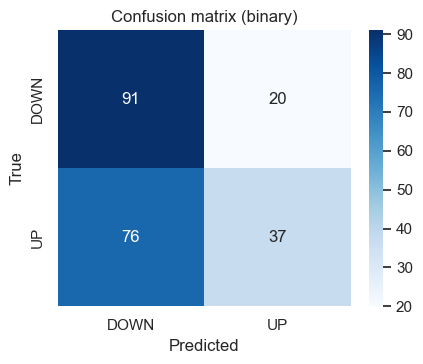


[CELL] Cell 27
Variables used in this cell:
  BINARY_TREND = True
  N_CLASSES = 2
  THRESHOLD_METRIC = 'bal_acc'
  TWO_STAGE (two-stage XGB (move + direction) flag) = False
  USE_THRESHOLD_TUNING = True
  XGBBaseline = <type XGBBaseline>
  X_test = ndarray shape=(224, 747) dtype=float64 sample=[ 75.82396902 210.44213078 113.27681638 356.78454857 359.37100795]
  X_test_scaled = ndarray shape=(224, 747) dtype=float64 sample=[-0.64949233  1.04423258 -0.33886905  6.94976844  0.79475241]
  X_train = ndarray shape=(1043, 747) dtype=float64 sample=[215.53405025 269.53543566 188.35197294 139.91479624 238.82595653]
  X_val = ndarray shape=(223, 747) dtype=float64 sample=[ 67.34343815 179.73538161  43.07274135  11.4518254  109.88918732]
  X_val_scaled = ndarray shape=(223, 747) dtype=float64 sample=[-0.67953264  0.75293375 -0.70980025 -1.18200816 -0.41195253]
  best_score = 0.5146347363328495
  best_t = 0.5599999999999999
  calc_metrics = <function calc_metrics>
  cm_title = 'Confusion matrix (

In [89]:

def print_ci(ci, key, name):
    if ci is None:
        return
    lo, hi = ci[key]
    print(f"  {name} 95% CI: [{lo:.4f}, {hi:.4f}]")


def print_basic_metrics(y_true, y_pred, lbls, names, title: str) -> None:
    print()
    print(title)

    metrics = calc_metrics(y_true, y_pred, lbls)
    print("Accuracy:", metrics["acc"])
    print("Balanced acc:", metrics["bal_acc"])
    print("MCC:", metrics["mcc"])
    print("F1 macro:", metrics["f1_macro"])
    print("Summary score (avg bal_acc + f1_macro):", metrics["summary"])

    counts = [int((y_true == lbl).sum()) for lbl in lbls]
    n = len(y_true)
    dist_parts = []
    for lbl, name, cnt in zip(lbls, names, counts):
        pct = 100.0 * cnt / n if n else 0.0
        dist_parts.append(f"{name}={cnt} ({pct:.1f}%)")
    print("Class distribution:", ", ".join(dist_parts))

    report_str = classification_report(
        y_true,
        y_pred,
        labels=lbls,
        target_names=names,
        zero_division=0,
    )
    report_dict = classification_report(
        y_true,
        y_pred,
        labels=lbls,
        target_names=names,
        output_dict=True,
        zero_division=0,
    )
    print("Classification report:")
    print(report_str)

    # Baseline 1: always predict majority class
    base_pred = majority_baseline_pred(y_true, lbls)
    base_metrics = calc_metrics(y_true, base_pred, lbls)
    print(
        f"Majority baseline -> acc={base_metrics['acc']:.4f}, "
        f"bal_acc={base_metrics['bal_acc']:.4f}, f1_macro={base_metrics['f1_macro']:.4f}, "
        f"summary={base_metrics['summary']:.4f}"
    )

    # Baseline 2: predict previous label (naive time baseline)
    prev_pred = prev_label_baseline_pred(y_true, fallback_label=lbls[0])
    prev_metrics = calc_metrics(y_true, prev_pred, lbls)
    print(
        f"Prev-label baseline -> acc={prev_metrics['acc']:.4f}, "
        f"bal_acc={prev_metrics['bal_acc']:.4f}, f1_macro={prev_metrics['f1_macro']:.4f}, "
        f"summary={prev_metrics['summary']:.4f}"
    )

    # Bootstrap CI for model metrics
    ci = bootstrap_metrics(y_true, y_pred, lbls, n_boot=200, seed=42)
    if ci is not None:
        print("Model 95% bootstrap CI:")
        print_ci(ci, "acc", "acc")
        print_ci(ci, "bal_acc", "bal_acc")
        print_ci(ci, "f1_macro", "f1_macro")
        print_ci(ci, "summary", "summary")

    # Sanity warnings
    warn_margin = 0.02
    if metrics["acc"] < max(base_metrics["acc"], prev_metrics["acc"]) + warn_margin:
        print("WARNING: accuracy barely above naive baselines")
    if metrics["bal_acc"] < max(base_metrics["bal_acc"], prev_metrics["bal_acc"]) + warn_margin:
        print("WARNING: balanced accuracy barely above naive baselines")
    if metrics["f1_macro"] < max(base_metrics["f1_macro"], prev_metrics["f1_macro"]) + warn_margin:
        print("WARNING: macro F1 barely above naive baselines")
    if metrics["summary"] < max(base_metrics["summary"], prev_metrics["summary"]) + warn_margin:
        print("WARNING: summary score barely above naive baselines")

    low_recall = []
    for name in names:
        if name in report_dict and report_dict[name]["recall"] < 0.2:
            low_recall.append(f"{name} (recall={report_dict[name]['recall']:.2f})")
    if low_recall:
        print("WARNING: low recall ->", ", ".join(low_recall))

    if len(counts) > 0 and min(counts) < 30:
        print("WARNING: some classes have <30 samples; metrics may be unstable")


def plot_confusion(y_true, y_pred, lbls, names, title: str) -> None:
    cm = confusion_matrix(y_true, y_pred, labels=lbls)
    plt.figure(figsize=(4.5, 3.8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=names,
        yticklabels=names,
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


if TWO_STAGE:
    print("Training mode: TWO_STAGE (MOVE/NO_MOVE -> UP/DOWN)")

    # --- Stage 1: MOVE vs NO_MOVE ---
    y_train_move = (y_train != 1).astype(np.int32)
    y_val_move = (y_val != 1).astype(np.int32)
    y_test_move = (y_test != 1).astype(np.int32)

    w_train_move = compute_sample_weight(class_weight="balanced", y=y_train_move)
    w_val_move = compute_sample_weight(class_weight="balanced", y=y_val_move)

    model_move = XGBBaseline(
        n_classes=2,
        device=device,
        random_state=42,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
    )

    model_move.fit(
        X_train, y_train_move,
        X_val=X_val, y_val=y_val_move,
        feature_names=feature_cols,
        sample_weight=w_train_move,
        sample_weight_val=w_val_move,
    )

    # --- Stage 2: direction (UP vs DOWN) only on MOVE rows ---
    mask_train_dir = y_train != 1
    mask_val_dir = y_val != 1
    mask_test_dir = y_test != 1

    X_train_dir = X_train[mask_train_dir]
    y_train_dir = (y_train[mask_train_dir] == 2).astype(np.int32)
    X_val_dir = X_val[mask_val_dir]
    y_val_dir = (y_val[mask_val_dir] == 2).astype(np.int32)

    w_train_dir = compute_sample_weight(class_weight="balanced", y=y_train_dir)
    w_val_dir = compute_sample_weight(class_weight="balanced", y=y_val_dir)

    model_dir = XGBBaseline(
        n_classes=2,
        device=device,
        random_state=42,
        n_estimators=300,
        max_depth=6,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
    )

    model_dir.fit(
        X_train_dir, y_train_dir,
        X_val=X_val_dir, y_val=y_val_dir,
        feature_names=feature_cols,
        sample_weight=w_train_dir,
        sample_weight_val=w_val_dir,
    )

    # --- Combine predictions to preserve the original sequence ---
    move_pred = model_move.predict(X_test)
    dir_pred_full = model_dir.predict(X_test)

    # If MOVE then UP/DOWN else SIDEWAYS(1)
    y_pred = np.where(move_pred == 1, np.where(dir_pred_full == 1, 2, 0), 1)
else:
    if BINARY_TREND:
        print("Training mode: SINGLE_STAGE (binary)")
    else:
        print("Training mode: SINGLE_STAGE (3 classes)")

    w_train = compute_sample_weight(class_weight="balanced", y=y_train)
    w_val = compute_sample_weight(class_weight="balanced", y=y_val)

    model = XGBBaseline(
        n_classes=N_CLASSES,
        device=device,
        random_state=42,
        n_estimators=1300,
        max_depth=10,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
    )

    model.fit(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        feature_names=feature_cols,
        sample_weight=w_train,
        sample_weight_val=w_val,
    )

    y_pred = model.predict(X_test)


# Optional threshold tuning for binary (reduce DOWN-only bias)
USE_THRESHOLD_TUNING = True
THRESHOLD_METRIC = "bal_acc"  # 'bal_acc' | 'f1_macro' | 'summary'

if BINARY_TREND and (not TWO_STAGE) and USE_THRESHOLD_TUNING:
    X_val_scaled = model.scaler.transform(X_val)
    proba_val = model.model.predict_proba(X_val_scaled)[:, 1]

    thresholds = np.linspace(0.05, 0.95, 91)
    best_t = 0.5
    best_score = -1.0
    for t in thresholds:
        pred_val = (proba_val >= t).astype(np.int32)
        m = calc_metrics(y_val, pred_val, [0, 1])
        score = m.get(THRESHOLD_METRIC, m['bal_acc'])
        if score > best_score:
            best_score = score
            best_t = float(t)

    print(f"Best threshold (val) = {best_t:.2f} using metric={THRESHOLD_METRIC} -> score={best_score:.4f}")

    X_test_scaled = model.scaler.transform(X_test)
    proba_test = model.model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (proba_test >= best_t).astype(np.int32)

# --- Metrics: overall 3-class ---
overall_title = "Overall (binary) metrics" if BINARY_TREND else "Overall (3-class) metrics"
print_basic_metrics(y_test, y_pred, label_ids, label_names, overall_title)
cm_title = "Confusion matrix (binary)" if BINARY_TREND else "Confusion matrix (3-class)"
plot_confusion(y_test, y_pred, label_ids, label_names, cm_title)

if TWO_STAGE:
    # Stage 1 metrics (MOVE vs NO_MOVE)
    move_names = ["NO_MOVE", "MOVE"]
    print_basic_metrics(y_test_move, move_pred, [0, 1], move_names, "Stage 1 (MOVE vs NO_MOVE) metrics")
    plot_confusion(y_test_move, move_pred, [0, 1], move_names, "Confusion matrix (MOVE vs NO_MOVE)")

    # Stage 2 metrics (UP vs DOWN) only on MOVE rows
    if mask_test_dir.sum() > 0:
        X_test_dir = X_test[mask_test_dir]
        y_test_dir = (y_test[mask_test_dir] == 2).astype(np.int32)
        dir_pred = model_dir.predict(X_test_dir)
        dir_names = ["DOWN", "UP"]
        print_basic_metrics(y_test_dir, dir_pred, [0, 1], dir_names, "Stage 2 (UP vs DOWN) metrics")
        plot_confusion(y_test_dir, dir_pred, [0, 1], dir_names, "Confusion matrix (UP vs DOWN)")
    else:
        print()
        print("Stage 2 metrics skipped: no MOVE samples in test set.")



trace_cell(
    title='Cell 27',
    used_vars=['BINARY_TREND', 'N_CLASSES', 'THRESHOLD_METRIC', 'TWO_STAGE', 'USE_THRESHOLD_TUNING', 'XGBBaseline', 'X_test', 'X_test_dir', 'X_test_scaled', 'X_train', 'X_train_dir', 'X_val', 'X_val_dir', 'X_val_scaled', 'best_score', 'best_t', 'calc_metrics', 'cm_title', 'compute_sample_weight', 'device', 'dir_names', 'dir_pred', 'dir_pred_full', 'feature_cols', 'label_ids', 'label_names', 'm', 'mask_test_dir', 'mask_train_dir', 'mask_val_dir', 'model', 'model_dir', 'model_move', 'move_names', 'move_pred', 'np', 'overall_title', 'plot_confusion', 'pred_val', 'print_basic_metrics', 'proba_test', 'proba_val', 'score', 't', 'thresholds', 'w_train', 'w_train_dir', 'w_train_move', 'w_val', 'w_val_dir', 'w_val_move', 'y_pred', 'y_test', 'y_test_dir', 'y_test_move', 'y_train', 'y_train_dir', 'y_train_move', 'y_val', 'y_val_dir', 'y_val_move'],
    show_missing=False,
)


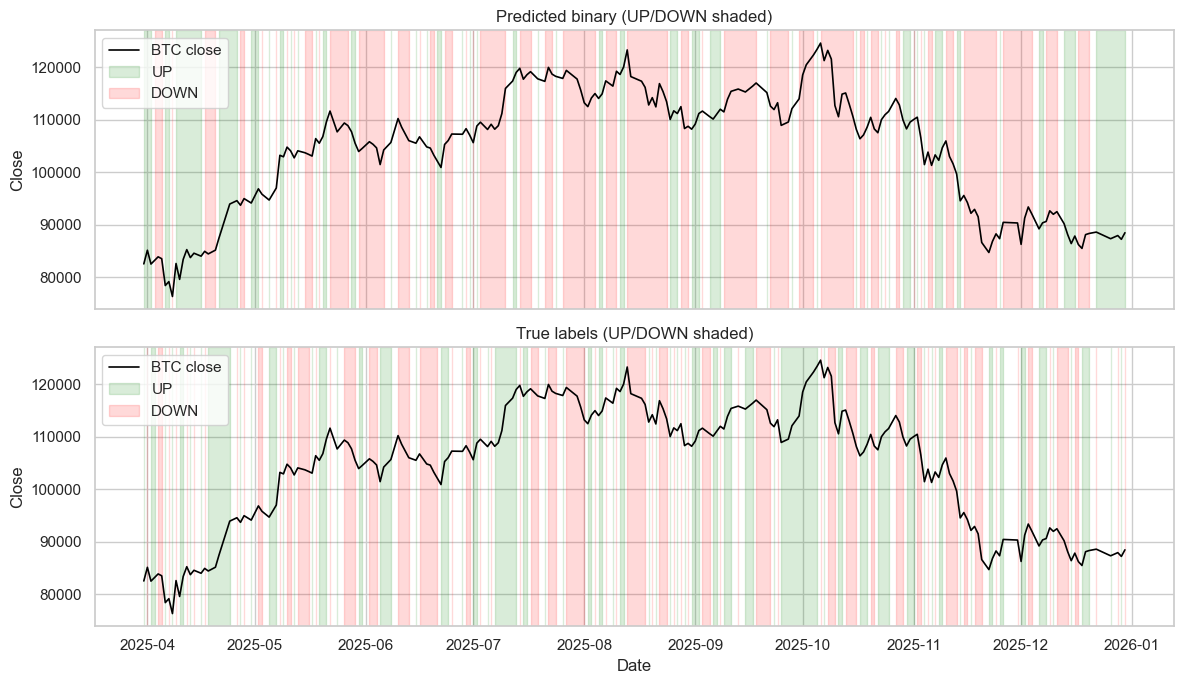


[CELL] Cell 28
Purpose: Plot BTC close with prediction background
Notes:
- Market dataframe is the price source for labels/plots.
Variables used in this cell:
  BINARY_TREND = True
  PLOT_END = None
  PLOT_LAST_N = 2400
  PLOT_PRICE_MODE = 'raw'
  PLOT_SCOPE = 'test'
  PLOT_START = None
  PRED_DIR_MASK_MOVE = False
  PRED_MODE = 'dir_only'
  PRICE_COL = 'close'
  SHOW_TRUE = True
  TWO_STAGE (two-stage XGB (move + direction) flag) = False
  X_plot = ndarray shape=(224, 747) dtype=float64 sample=[ 75.82396902 210.44213078 113.27681638 356.78454857 359.37100795]
  ax = <Axes: title={'center': 'Balanced labels (UP/DOWN)'}, xlabel='Date', ylabel='Close'>
  axes = ndarray shape=(2,) dtype=object sample=[<Axes: title={'center': 'Predicted binary (UP/DOWN shaded)'}, ylabel='Close'>
 <Axes: title={'center': 'True labels (UP/DOWN shaded)'}, xlabel='Date', ylabel='Close'>]
  base_df = DataFrame shape=(224, 749) cols_count=749 cols_preview=['date', 'Jupiter_lon', 'Lilith_lon', 'Mars_lon', 'MeanN

In [90]:

# Plot BTC close with prediction background
# Green: UP, Red: DOWN, no color: SIDEWAYS

# --- Plot options ---
PLOT_SCOPE = "test"  # "test", "val", "train", "full"
PLOT_START = None    # e.g. "2023-01-01"
PLOT_END = None      # e.g. "2024-01-01"
PLOT_LAST_N = 2400    # set None to disable
PRED_MODE = "dir_only"  # "three_class" or "dir_only"
PRED_DIR_MASK_MOVE = False  # if True, show dir preds only when MOVE predicted
SHOW_TRUE = True           # second panel with true labels
PRICE_COL = "close"

# Select base dataframe
if PLOT_SCOPE == "full":
    base_df = df_dataset.copy()
elif PLOT_SCOPE == "train":
    base_df = train_df.copy()
elif PLOT_SCOPE == "val":
    base_df = val_df.copy()
else:
    base_df = test_df.copy()

if PLOT_SCOPE != "test":
    print("NOTE: PLOT_SCOPE is not test; this is in-sample visualization.")

base_df["date"] = pd.to_datetime(base_df["date"])

# Compute predictions for chosen scope
X_plot = base_df[feature_cols].to_numpy(dtype=np.float64)
if TWO_STAGE:
    move_pred_plot = model_move.predict(X_plot)
    dir_pred_plot = model_dir.predict(X_plot)
    pred_3c_plot = np.where(move_pred_plot == 1, np.where(dir_pred_plot == 1, 2, 0), 1)
else:
    move_pred_plot = np.full(len(base_df), np.nan)
    dir_pred_plot = np.full(len(base_df), np.nan)
    pred_3c_plot = model.predict(X_plot)

plot_df = base_df[["date", "target"]].copy()
plot_df["pred_3c"] = pred_3c_plot
plot_df["pred_move"] = move_pred_plot
plot_df["pred_dir"] = dir_pred_plot

market_dates = df_market[["date", PRICE_COL]].copy()
market_dates["date"] = pd.to_datetime(market_dates["date"])

plot_df = plot_df.merge(market_dates, on="date", how="left")
plot_df = plot_df.dropna(subset=[PRICE_COL]).sort_values("date").reset_index(drop=True)

# Apply date window
if PLOT_START is not None:
    plot_df = plot_df[plot_df["date"] >= pd.to_datetime(PLOT_START)]
if PLOT_END is not None:
    plot_df = plot_df[plot_df["date"] <= pd.to_datetime(PLOT_END)]
if PLOT_LAST_N is not None and len(plot_df) > PLOT_LAST_N:
    plot_df = plot_df.tail(PLOT_LAST_N)

if plot_df.empty:
    raise ValueError("Plot window is empty. Check PLOT_START/PLOT_END/PLOT_LAST_N")

# Helper to shade UP/DOWN zones

def shade_up_down(ax, dates, close, up_mask, down_mask, title: str, y_label: str):
    ax.plot(dates, close, color="black", linewidth=1.2, label="BTC close")
    ax.fill_between(
        dates,
        0,
        1,
        where=up_mask,
        transform=ax.get_xaxis_transform(),
        color="green",
        alpha=0.15,
        label="UP",
    )
    ax.fill_between(
        dates,
        0,
        1,
        where=down_mask,
        transform=ax.get_xaxis_transform(),
        color="red",
        alpha=0.15,
        label="DOWN",
    )
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.legend(loc="upper left")

# Choose prediction masks
preds_3c = plot_df["pred_3c"].to_numpy()
if BINARY_TREND:
    up_mask_pred = preds_3c == 1
    down_mask_pred = preds_3c == 0
    title_pred = "Predicted binary (UP/DOWN shaded)"
elif PRED_MODE == "dir_only" and TWO_STAGE:
    dir_pred = plot_df["pred_dir"].to_numpy().astype(int)
    if PRED_DIR_MASK_MOVE:
        move_mask = plot_df["pred_move"].to_numpy() == 1
        up_mask_pred = (dir_pred == 1) & move_mask
        down_mask_pred = (dir_pred == 0) & move_mask
        title_pred = "Predicted direction (dir model, MOVE only)"
    else:
        up_mask_pred = dir_pred == 1
        down_mask_pred = dir_pred == 0
        title_pred = "Predicted direction (dir model, all points)"
else:
    up_mask_pred = preds_3c == 2
    down_mask_pred = preds_3c == 0
    title_pred = "Predicted 3-class (UP/DOWN shaded)"

dates = plot_df["date"].to_numpy()
close = plot_df[PRICE_COL].to_numpy()
if PLOT_PRICE_MODE == 'log':
    close = np.log(close)
    y_label = 'log(price)'
else:
    y_label = 'Close'

if SHOW_TRUE:
    fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
    shade_up_down(axes[0], dates, close, up_mask_pred, down_mask_pred, title_pred, y_label)

    true_labels = plot_df["target"].to_numpy()
    if BINARY_TREND:
        up_mask_true = true_labels == 1
        down_mask_true = true_labels == 0
    else:
        up_mask_true = true_labels == 2
        down_mask_true = true_labels == 0
    shade_up_down(axes[1], dates, close, up_mask_true, down_mask_true, "True labels (UP/DOWN shaded)", y_label)

    axes[1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()
else:
    fig, ax = plt.subplots(figsize=(12, 4))
    shade_up_down(ax, dates, close, up_mask_pred, down_mask_pred, title_pred, y_label)
    ax.set_xlabel("Date")
    plt.tight_layout()
    plt.show()





trace_cell(
    title='Cell 28',
    purpose='Plot BTC close with prediction background',
    used_vars=['BINARY_TREND', 'PLOT_END', 'PLOT_LAST_N', 'PLOT_PRICE_MODE', 'PLOT_SCOPE', 'PLOT_START', 'PRED_DIR_MASK_MOVE', 'PRED_MODE', 'PRICE_COL', 'SHOW_TRUE', 'TWO_STAGE', 'X_plot', 'ax', 'axes', 'base_df', 'close', 'dates', 'df_dataset', 'df_market', 'dir_pred', 'dir_pred_plot', 'down_mask_pred', 'down_mask_true', 'feature_cols', 'market_dates', 'model', 'model_dir', 'model_move', 'move_mask', 'move_pred_plot', 'np', 'pd', 'plot_df', 'plt', 'pred_3c_plot', 'preds_3c', 'shade_up_down', 'test_df', 'title_pred', 'train_df', 'true_labels', 'up_mask_pred', 'up_mask_true', 'val_df', 'y_label'],
    notes=['Market dataframe is the price source for labels/plots.'],
    show_missing=False,
)


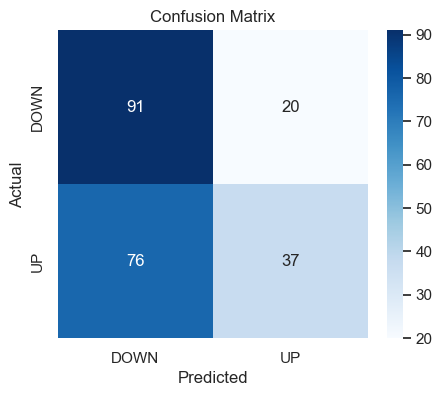


[CELL] Cell 29
Purpose: Confusion matrix
Variables used in this cell:
  BINARY_TREND = True
  cm = ndarray shape=(2, 2) dtype=int64 sample=[91 20 76 37]
  confusion_matrix = <function confusion_matrix>
  labels = list len=2 sample=['DOWN', 'UP']
  lbl_ids = list len=2 sample=[0, 1]
  plt = <module matplotlib.pyplot>
  sns = <module seaborn>
  y_pred = ndarray shape=(224,) dtype=int32 sample=[1 0 1 0 0]
  y_test = ndarray shape=(224,) dtype=int32 sample=[1 0 1 1 0]


In [91]:

# Confusion matrix
from sklearn.metrics import confusion_matrix

if BINARY_TREND:
    labels = ['DOWN', 'UP']
    lbl_ids = [0, 1]
else:
    labels = ['DOWN', 'SIDEWAYS', 'UP']
    lbl_ids = [0, 1, 2]

cm = confusion_matrix(y_test, y_pred, labels=lbl_ids)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




trace_cell(
    title='Cell 29',
    purpose='Confusion matrix',
    used_vars=['BINARY_TREND', 'cm', 'confusion_matrix', 'labels', 'lbl_ids', 'plt', 'sns', 'y_pred', 'y_test'],
    show_missing=False,
)


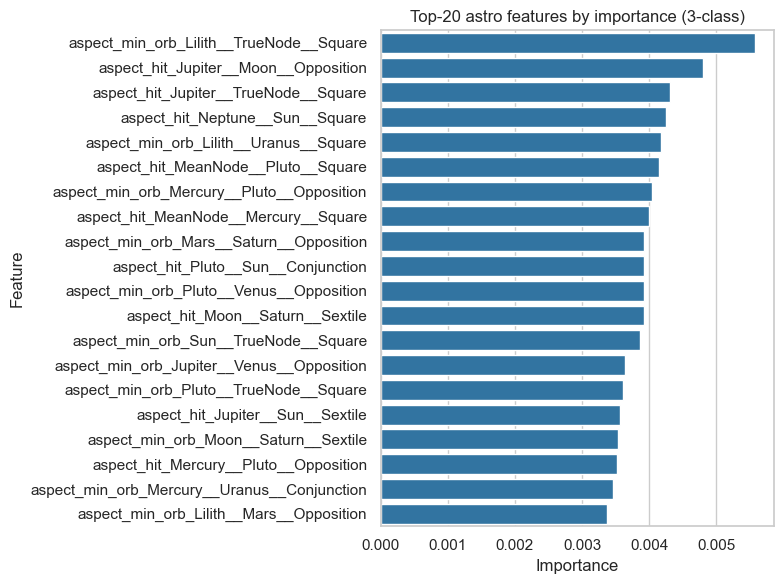


[CELL] Cell 30
Purpose: Feature importance (top 20)
Variables used in this cell:
  IMP_MODEL_STAGE = 'dir'
  TWO_STAGE (two-stage XGB (move + direction) flag) = False
  feature_cols (feature column names used for model training) = list len=747 sample=['Jupiter_lon', 'Lilith_lon', 'Mars_lon', 'MeanNode_lon', 'Mercury_lon']...
  imp_df = DataFrame shape=(747, 2) cols_count=2 cols_preview=['feature', 'importance'] head=
                                     feature  importance
503  aspect_min_orb_Lilith__TrueNode__Square    0.005577
84      aspect_hit_Jupiter__Moon__Opposition    0.004802
108     aspect_hit_Jupiter__TrueNode__Square    0.004310
  importances = ndarray shape=(747,) dtype=float32 sample=[0.00131681 0.00105452 0.00119854 0.00100825 0.00147033]
  model (single-stage model wrapper) = <src.models.xgb.XGBBaseline object at 0x000001F4ED86B710>
  pd = <module pandas>
  plt = <module matplotlib.pyplot>
  sns = <module seaborn>
  stage_model = <src.models.xgb.XGBBaseline object at 0

In [92]:

# Feature importance (top 20)
# In two-stage mode you can plot one stage or both.
IMP_MODEL_STAGE = "dir"  # "dir", "move", or "both"

if TWO_STAGE:
    if IMP_MODEL_STAGE == "both":
        stage_models = [
            ("MOVE vs NO_MOVE", model_move),
            ("UP vs DOWN", model_dir),
        ]
    elif IMP_MODEL_STAGE == "move":
        stage_models = [("MOVE vs NO_MOVE", model_move)]
    else:
        stage_models = [("UP vs DOWN", model_dir)]
else:
    stage_models = [("3-class", model)]

for stage_name, stage_model in stage_models:
    importances = stage_model.model.feature_importances_
    imp_df = pd.DataFrame({
        "feature": feature_cols,
        "importance": importances,
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=imp_df.head(20), x="importance", y="feature", color="tab:blue")
    plt.title(f"Top-20 astro features by importance ({stage_name})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()





trace_cell(
    title='Cell 30',
    purpose='Feature importance (top 20)',
    used_vars=['IMP_MODEL_STAGE', 'TWO_STAGE', 'feature_cols', 'imp_df', 'importances', 'model', 'model_dir', 'model_move', 'pd', 'plt', 'sns', 'stage_model', 'stage_models', 'stage_name'],
    show_missing=False,
)


In [93]:

# Save model (optional)
from joblib import dump

artifact_dir = PROJECT_ROOT / "models_artifacts"
artifact_dir.mkdir(parents=True, exist_ok=True)

artifact_config = {
    "label_mode": LABEL_MODE,
    "label_price_mode": LABEL_PRICE_MODE,
    "move_share_total": MOVE_SHARE_TOTAL,
    "gauss_window": GAUSS_WINDOW,
    "gauss_std": GAUSS_STD,
    "horizon": HORIZON,
}

if TWO_STAGE:
    artifact = {
        "mode": "two_stage",
        "move": {
            "model": model_move.model,
            "scaler": model_move.scaler,
        },
        "dir": {
            "model": model_dir.model,
            "scaler": model_dir.scaler,
        },
        "feature_names": feature_cols,
        "config": artifact_config,
    }
    out_path = artifact_dir / f"xgb_astro_balanced_two_stage_h{HORIZON}.joblib"
else:
    artifact = {
        "mode": "single_stage",
        "model": model.model,
        "scaler": model.scaler,
        "feature_names": feature_cols,
        "config": artifact_config,
    }
    out_path = artifact_dir / f"xgb_astro_balanced_h{HORIZON}.joblib"

dump(artifact, out_path)
print(f"Saved: {out_path}")




trace_cell(
    title='Cell 31',
    purpose='Save model (optional)',
    used_vars=['GAUSS_STD', 'GAUSS_WINDOW', 'HORIZON', 'LABEL_MODE', 'LABEL_PRICE_MODE', 'MOVE_SHARE_TOTAL', 'PROJECT_ROOT', 'TWO_STAGE', 'artifact', 'artifact_config', 'artifact_dir', 'dump', 'feature_cols', 'model', 'model_dir', 'model_move', 'out_path'],
    show_missing=False,
)


Saved: C:\_PYTH\projects\PythonProject\ostrofun\models_artifacts\xgb_astro_balanced_h1.joblib

[CELL] Cell 31
Purpose: Save model (optional)
Variables used in this cell:
  GAUSS_STD (Gaussian std for centered detrend) = 70.0
  GAUSS_WINDOW (Gaussian window size (odd) for centered detrend) = 201
  HORIZON (prediction horizon (days ahead)) = 1
  LABEL_MODE (labeling mode (balanced_future_return / balanced_detrended)) = 'balanced_detrended'
  LABEL_PRICE_MODE (labeling price space: 'log' or 'raw') = 'raw'
  MOVE_SHARE_TOTAL (total share kept (split up/down)) = 0.5
  PROJECT_ROOT = Path('C:\_PYTH\projects\PythonProject\ostrofun')
  TWO_STAGE (two-stage XGB (move + direction) flag) = False
  artifact = dict keys_count=5 keys_preview=['mode', 'model', 'scaler', 'feature_names', 'config']
  artifact_config = dict keys_count=6 keys_preview=['label_mode', 'label_price_mode', 'move_share_total', 'gauss_window', 'gauss_std']...
  artifact_dir = Path('C:\_PYTH\projects\PythonProject\ostrofun\model

## 8. Ideas for improvement

- Pick sigma/threshold based on model metrics, not only class balance.
- Add transit-to-natal aspects as extra features.
- Use separate models for different market regimes.


In [94]:





trace_cell(
    title='Cell 33',
    used_vars=[],
    show_missing=False,
)



[CELL] Cell 33


In [95]:

trace_cell(
    title='Cell 34',
    used_vars=[],
    show_missing=False,
)



[CELL] Cell 34


In [96]:

trace_cell(
    title='Cell 35',
    used_vars=[],
    show_missing=False,
)



[CELL] Cell 35
